In [58]:
import pandas as pd
import numpy as np
from scipy.stats import skew
from scipy.stats import spearmanr

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet, LassoLars
from sklearn.svm import SVR

from xgboost import XGBRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
import catboost
from catboost import CatBoostRegressor

from supervised.automl import AutoML

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt # seaborn figure 크기 조절을 위해서
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
# 운영체제별 한글 폰트 설정
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False) # 마이너스 폰트 설정
# 글씨 선명하게 출력하는 설정
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

SEED = 2
np.random.seed(SEED)

# 건물유형별 에너지소비 예측성능 향상을 위한 변수중요도 및 기계학습모델 평가 p.6 CVRMSE
def cvrmse_score(y_true, y_pred):
    return ((np.sqrt(mean_squared_error(y_true, y_pred))) / y_true.mean() ) * 100 

In [59]:
# import csv
# import json

# data = []
# with open('data/preprocessing.csv', 'r', encoding='utf-8') as csv_file:
#     reader = csv.DictReader(csv_file)
#     data = list(reader)

# with open('data/preprocessing.json', 'w') as json_file:
#     json.dump(data, json_file)

# 전처리한 에너지 관련 데이터 및 기상 데이터 불러오기

In [60]:
# concatenated_df.to_csv('preprocessing.csv')
# concatenated_df = pd.read_csv('data/preprocessing.csv', index_col=0)
concatenated_df = pd.read_csv('data/hj_data_preprocessing.csv', index_col=0)
df_weather = pd.read_csv('data/weather.csv', index_col=0)

concatenated_df['useDate'] = pd.to_datetime(concatenated_df['useDate'])
df_weather['useDate'] = pd.to_datetime(df_weather['useDate'])

In [61]:
concatenated_df.loc[concatenated_df['useType'] == '냉난방', 'useType'] = 'Cooling'
concatenated_df.loc[concatenated_df['useType'] == '전열', 'useType'] = 'EPU'
concatenated_df.loc[concatenated_df['useType'] == '조명', 'useType'] = 'Lighting'

## 두 자료 합치기 위한 전처리

In [62]:
df_toe = concatenated_df[['useDate'	,'zone_id',	'energyTypeNo',	'useType',	'toeQty']]
df_toe['toeQty'] *= 1000

In [63]:
df_toe = df_toe[df_toe['energyTypeNo'] == 'ELC']

In [64]:
# df_useType_15min = df_toe.groupby(['useDate','useType'])['toeQty'].sum().reset_index()
df_useType = df_toe.groupby(['useDate','useType'])['toeQty'].sum().reset_index()
# df_total_15min = df_toe.groupby(['useDate'])['toeQty'].sum().reset_index()
df_total = df_toe.groupby(['useDate'])['toeQty'].sum().reset_index()

In [65]:
# df_useType_1hr = df_useType_15min.groupby([df_useType_15min['useDate'].dt.floor('H'),'useType'])['toeQty'].sum().reset_index()
# df_total_1hr = df_total_15min.groupby([df_total_15min['useDate'].dt.floor('H')])['toeQty'].sum().reset_index()
df_useType_1hr = df_useType.copy()
df_total_1hr = df_total.copy()
df_total_1hr['useType'] = 'Total'

In [66]:
df_1hr = pd.concat([df_useType_1hr, df_total_1hr], ignore_index=True).sort_values(by=['useDate', 'useType'], ascending=True).reset_index(drop=True)
df_1hr.tail(10)

useDate   useType  toeQty
6998 2023-10-19 21:00:00  Lighting   137.4
6999 2023-10-19 21:00:00     Total  1099.2
7000 2023-10-19 22:00:00   Cooling    68.7
7001 2023-10-19 22:00:00       EPU   687.0
7002 2023-10-19 22:00:00  Lighting    45.8
7003 2023-10-19 22:00:00     Total   801.5
7004 2023-10-19 23:00:00   Cooling    91.6
7005 2023-10-19 23:00:00       EPU   687.0
7006 2023-10-19 23:00:00  Lighting    45.8
7007 2023-10-19 23:00:00     Total   824.4

In [67]:
# df_useType_1hr['useDate'] = pd.to_datetime(df_useType_1hr['useDate'])

# df_useType_1hr['date'] = df_useType_1hr['useDate'].dt.date 

# df_useType_1hr['month'] = df_useType_1hr['useDate'].dt.month
# df_useType_1hr['day'] = df_useType_1hr['useDate'].dt.day
# df_useType_1hr['hour'] = df_useType_1hr['useDate'].dt.hour
# df_useType_1hr['weekday'] = df_useType_1hr['useDate'].dt.day_of_week

# selected_dates = ['2023-08-15', '2023-09-28', '2023-09-29', '2023-09-30', '2023-10-01', '2023-10-02', '2023-10-09']
# df_useType_1hr['holiday'] = np.where((df_useType_1hr.useDate.dt.strftime('%Y-%m-%d').isin(selected_dates)), 1, 0)

# df_total_1hr['useDate'] = pd.to_datetime(df_total_1hr['useDate'])

# df_total_1hr['date'] = df_total_1hr['useDate'].dt.date 

# df_total_1hr['month'] = df_total_1hr['useDate'].dt.month
# df_total_1hr['day'] = df_total_1hr['useDate'].dt.day
# df_total_1hr['hour'] = df_total_1hr['useDate'].dt.hour
# df_total_1hr['weekday'] = df_total_1hr['useDate'].dt.day_of_week

# df_total_1hr['holiday'] = 0

# selected_dates = ['2023-08-15', '2023-09-28', '2023-09-29', '2023-09-30', '2023-10-01', '2023-10-02', '2023-10-09']
# df_total_1hr['holiday'] = np.where((df_total_1hr.useDate.dt.strftime('%Y-%m-%d').isin(selected_dates)), 1, 0)

In [68]:
df_1hr['useDate'] = pd.to_datetime(df_1hr['useDate'])

df_1hr['date'] = df_1hr['useDate'].dt.date 

df_1hr['month'] = df_1hr['useDate'].dt.month
df_1hr['day'] = df_1hr['useDate'].dt.day
df_1hr['hour'] = df_1hr['useDate'].dt.hour
df_1hr['weekday'] = df_1hr['useDate'].dt.day_of_week

df_1hr['holiday'] = 0

selected_dates = ['2023-08-15', '2023-09-28', '2023-09-29', '2023-09-30', '2023-10-01', '2023-10-02', '2023-10-09']
df_1hr['holiday'] = np.where((df_1hr.useDate.dt.strftime('%Y-%m-%d').isin(selected_dates)), 1, 0)

In [69]:
df_1hr = pd.merge(df_1hr, df_weather, on='useDate', how='inner')
df_1hr

useDate   useType  toeQty        date  month  day  hour  \
0    2023-08-08 00:00:00   Cooling    68.7  2023-08-08      8    8     0   
1    2023-08-08 00:00:00       EPU   801.5  2023-08-08      8    8     0   
2    2023-08-08 00:00:00  Lighting    22.9  2023-08-08      8    8     0   
3    2023-08-08 00:00:00     Total   893.1  2023-08-08      8    8     0   
4    2023-08-08 01:00:00   Cooling   114.5  2023-08-08      8    8     1   
...                  ...       ...     ...         ...    ...  ...   ...   
7195 2023-10-19 22:00:00     Total   801.5  2023-10-19     10   19    22   
7196 2023-10-19 23:00:00   Cooling    91.6  2023-10-19     10   19    23   
7197 2023-10-19 23:00:00       EPU   687.0  2023-10-19     10   19    23   
7198 2023-10-19 23:00:00  Lighting    45.8  2023-10-19     10   19    23   
7199 2023-10-19 23:00:00     Total   824.4  2023-10-19     10   19    23   

      weekday  holiday  temp  rain  wind  hum   ss   sr  
0           1        0  25.0   0.0   2.3   83  0.0  0.0  
1           1        0  25.0   0.0   2.3   83  0.0  0.0  
2           1        0  25.0   0.0   2.3   83  0.0  0.0  
3           1        0  25.0   0.0   2.3   83  0.0  0.0  
4           1        0  25.0   0.0   2.2   83  0.0  0.0  
...       ...      ...   ...   ...   ...  ...  ...  ...  
7195        3        0  18.8   0.0   1.2   65  0.0  0.0  
7196        3        0  17.8   0.0   2.8   64  0.0  0.0  
7197        3        0  17.8   0.0   2.8   64  0.0  0.0  
7198        3        0  17.8   0.0   2.8   64  0.0  0.0  
7199        3        0  17.8   0.0   2.8   64  0.0  0.0  

[7200 rows x 15 columns]

In [70]:
df_1hr['operating'] = np.where((df_1hr['hour'] >= 9) & (df_1hr['hour'] <= 18), 1, 0)

In [71]:
df_1hr_l2 = df_1hr.copy()
df_1hr_l2['toeQty'] = df_1hr_l2['toeQty'] / np.linalg.norm(df_1hr_l2['toeQty'], axis=0)

# EDA

## 시계열

### 전체시간

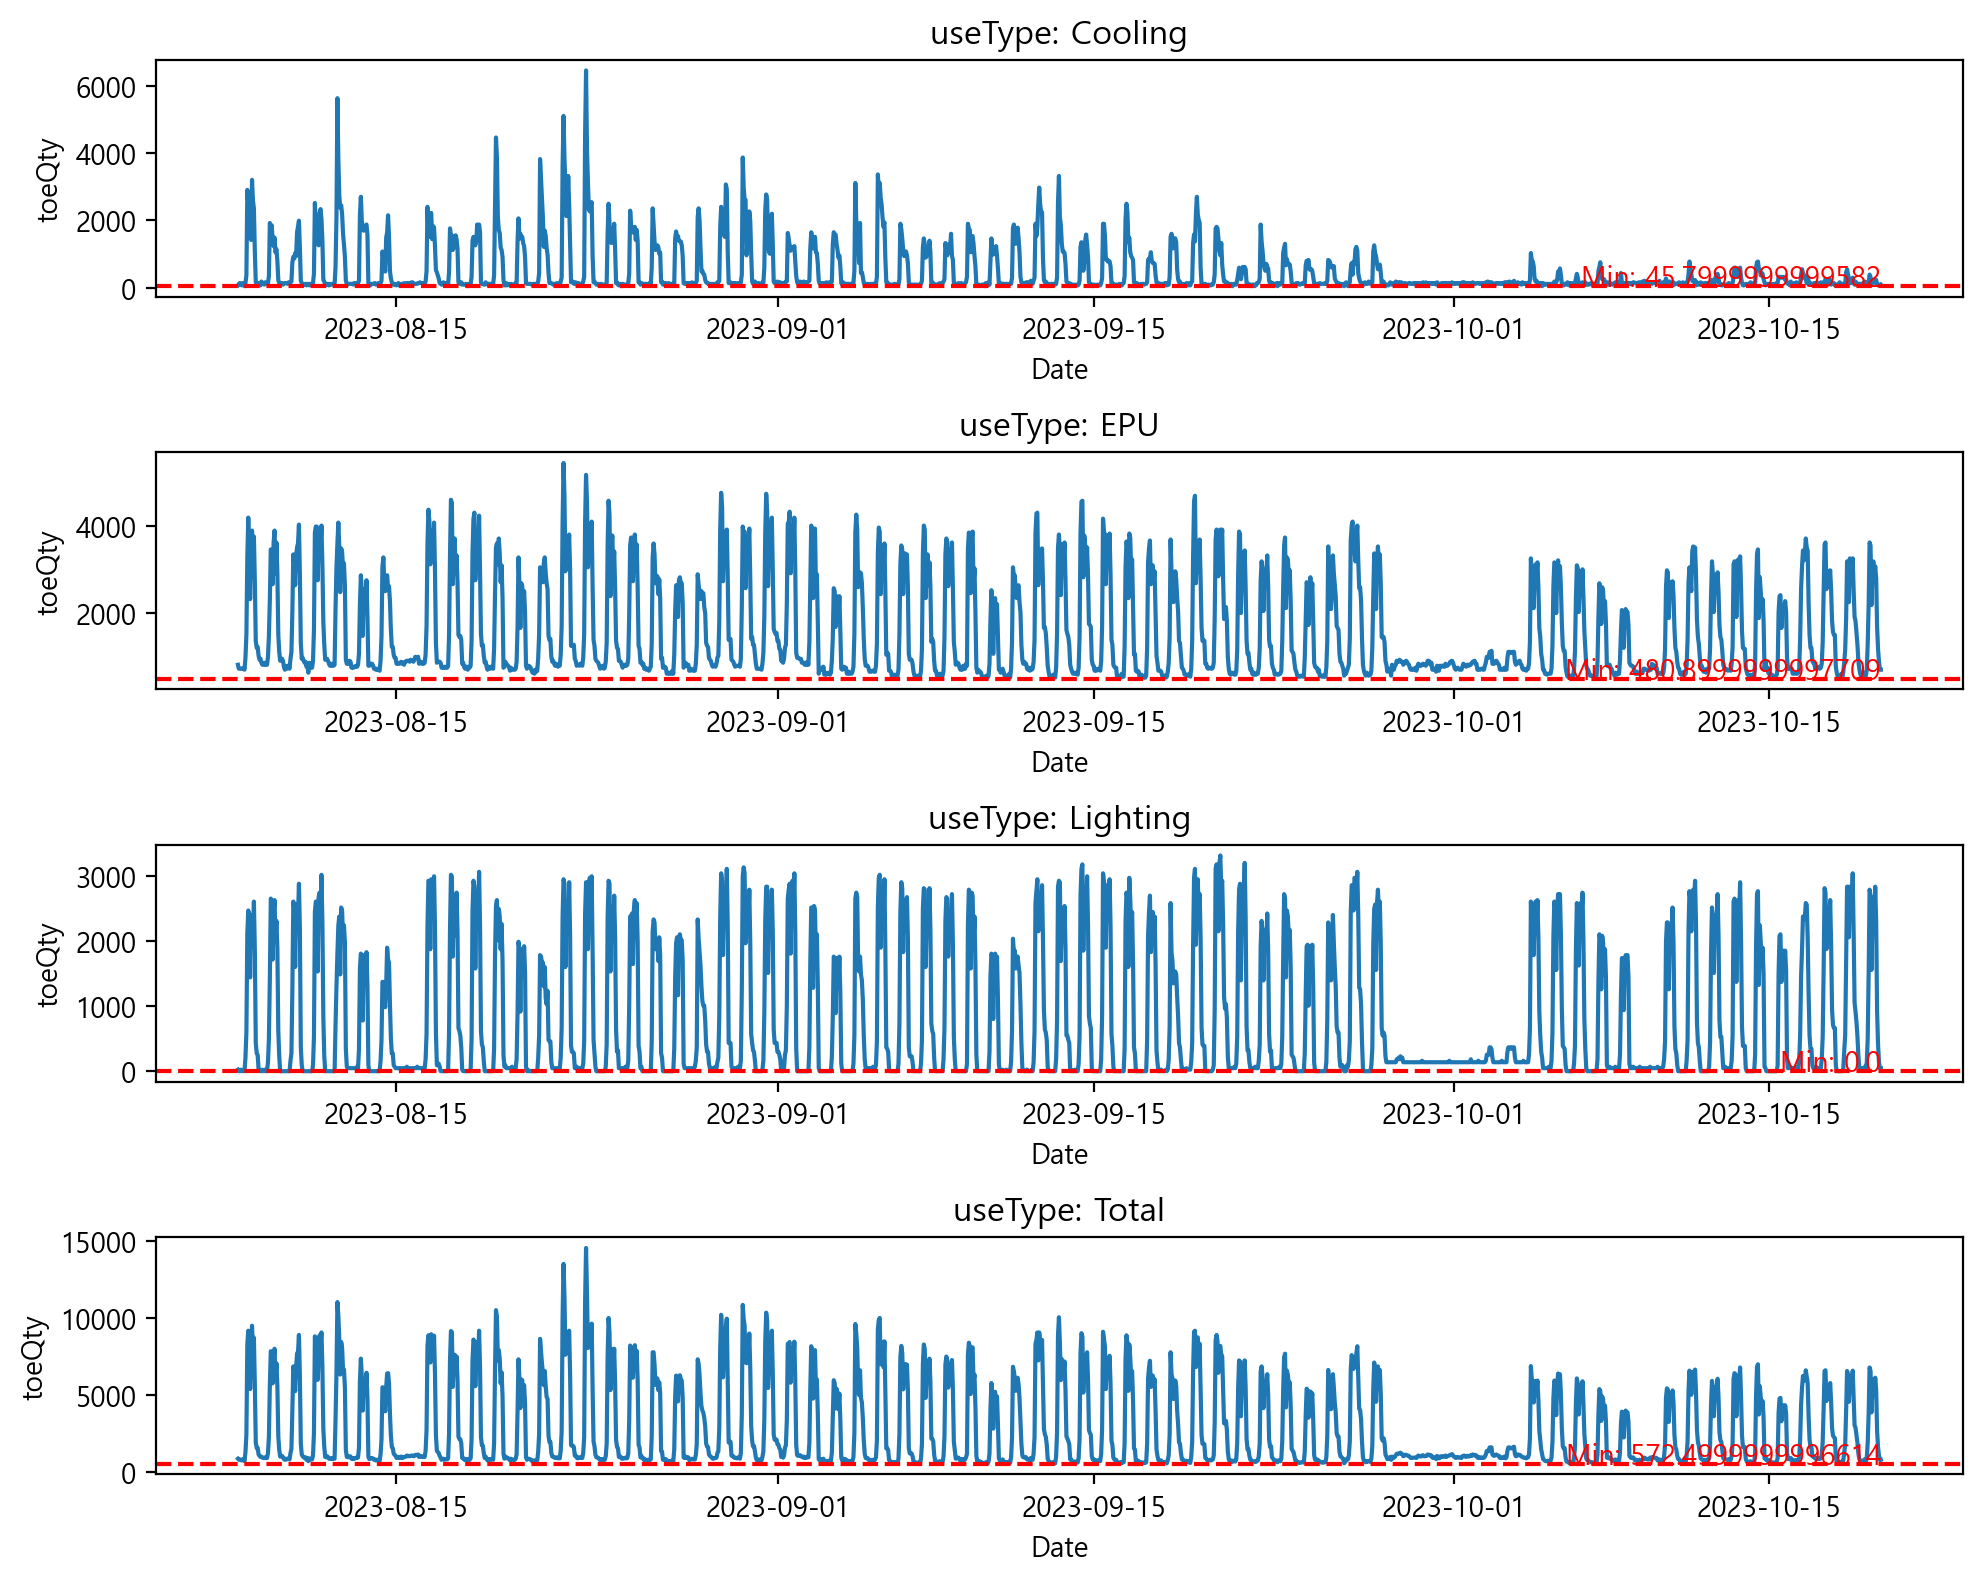

In [72]:
useTypes = df_1hr['useType'].unique()

fig, axes = plt.subplots(nrows=len(useTypes), figsize=(10, 8))

for i, useType in enumerate(useTypes):
    df_useType = df_1hr[df_1hr['useType'] == useType]
    axes[i].plot(df_useType['useDate'], df_useType['toeQty'])
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('toeQty')
    axes[i].set_title(f'useType: {useType}')
    
    # Add a red line for the minimum value
    min_value = df_useType['toeQty'].min()
    axes[i].axhline(min_value, color='red', linestyle='--')
    axes[i].text(df_useType['useDate'].max(), min_value, f'Min: {min_value}', color='red', ha='right')

plt.tight_layout()
plt.show()

### 주간(평균값)

#### 휴일포함

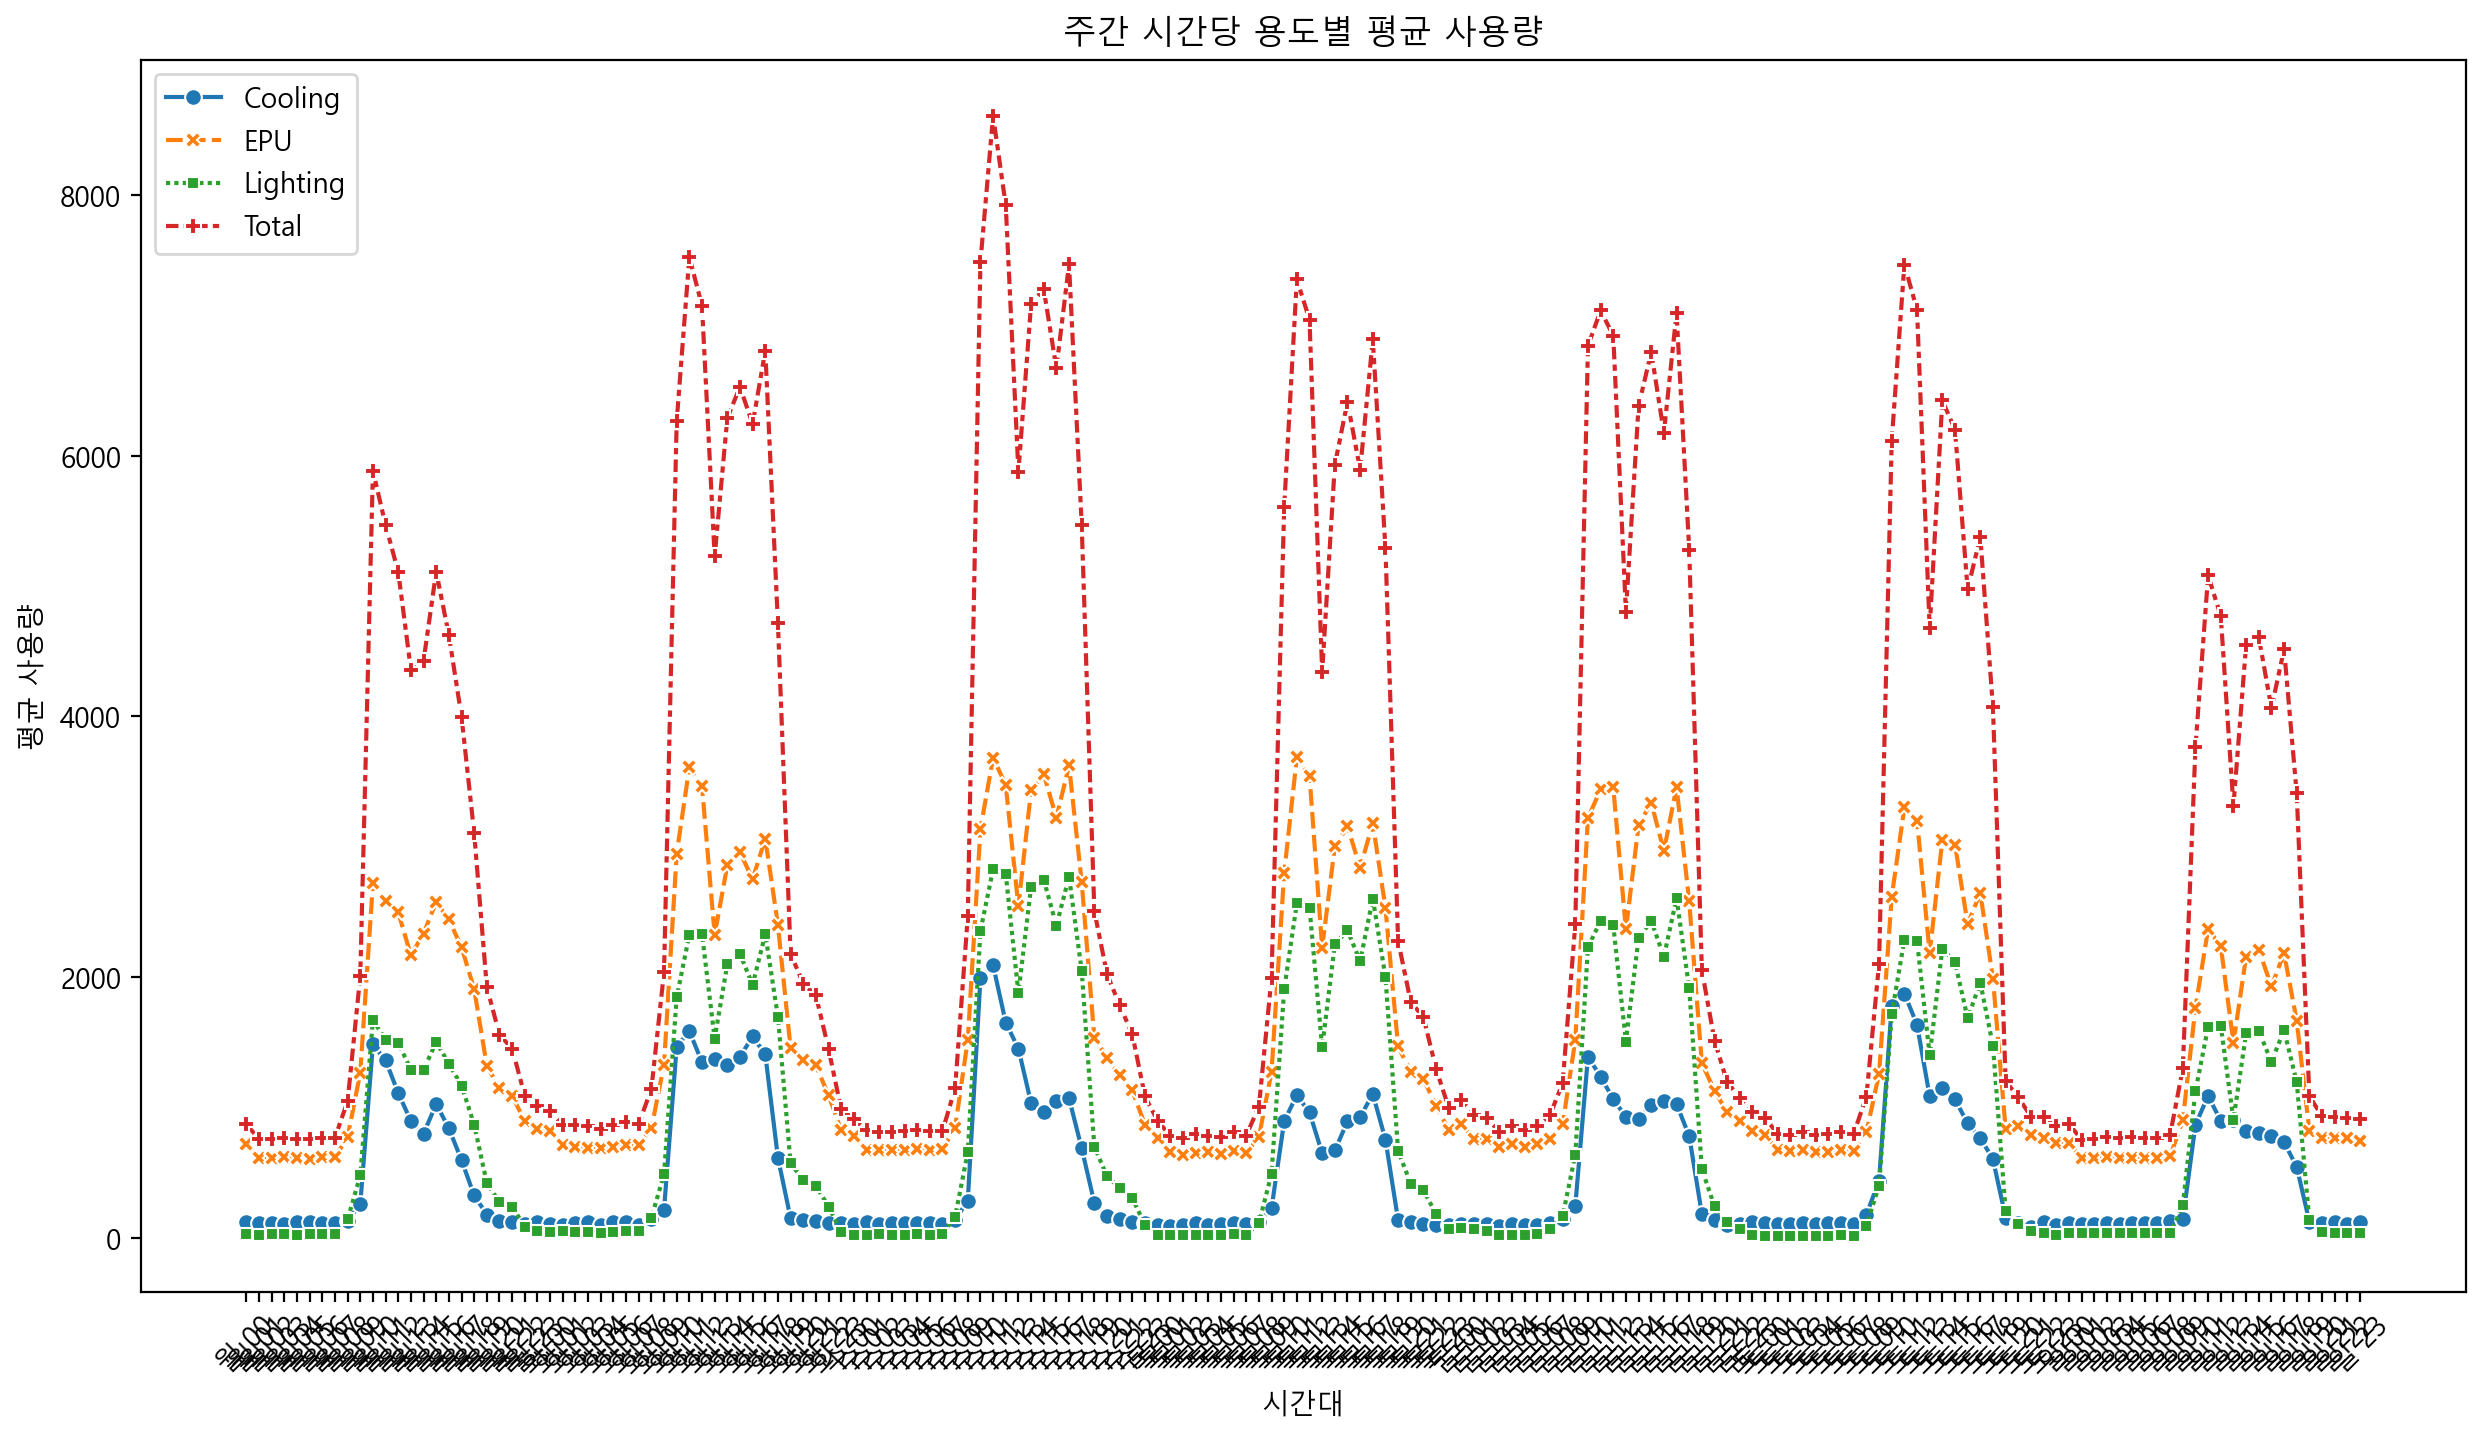

In [73]:
# 월요일부터 일요일까지 시간대별 용도별 평균값 계산
result = df_1hr.groupby(['weekday', 'hour', 'useType'])['toeQty'].mean().reset_index()

weekday_list = ['월', '화', '수', '목', '금', '토', '일']

# 시각화
plt.figure(figsize=(15, 8))

# x축을 요일과 시간대로 설정
x_labels = [f'{weekday_list[day]} {hour:02d}' for day, hour in zip(result['weekday'], result['hour'])]
sns.lineplot(data=result, x=x_labels, y='toeQty', hue='useType', markers=True, style='useType')

# 그래프 제목 설정
plt.title('주간 시간당 용도별 평균 사용량')

# x축과 y축 레이블 설정
plt.xlabel('시간대')
plt.ylabel('평균 사용량')

# 범례 위치 설정
plt.legend(loc='upper left')

# x축 레이블 각도 조정
plt.xticks(rotation=45)

plt.show()

#### 휴일제외

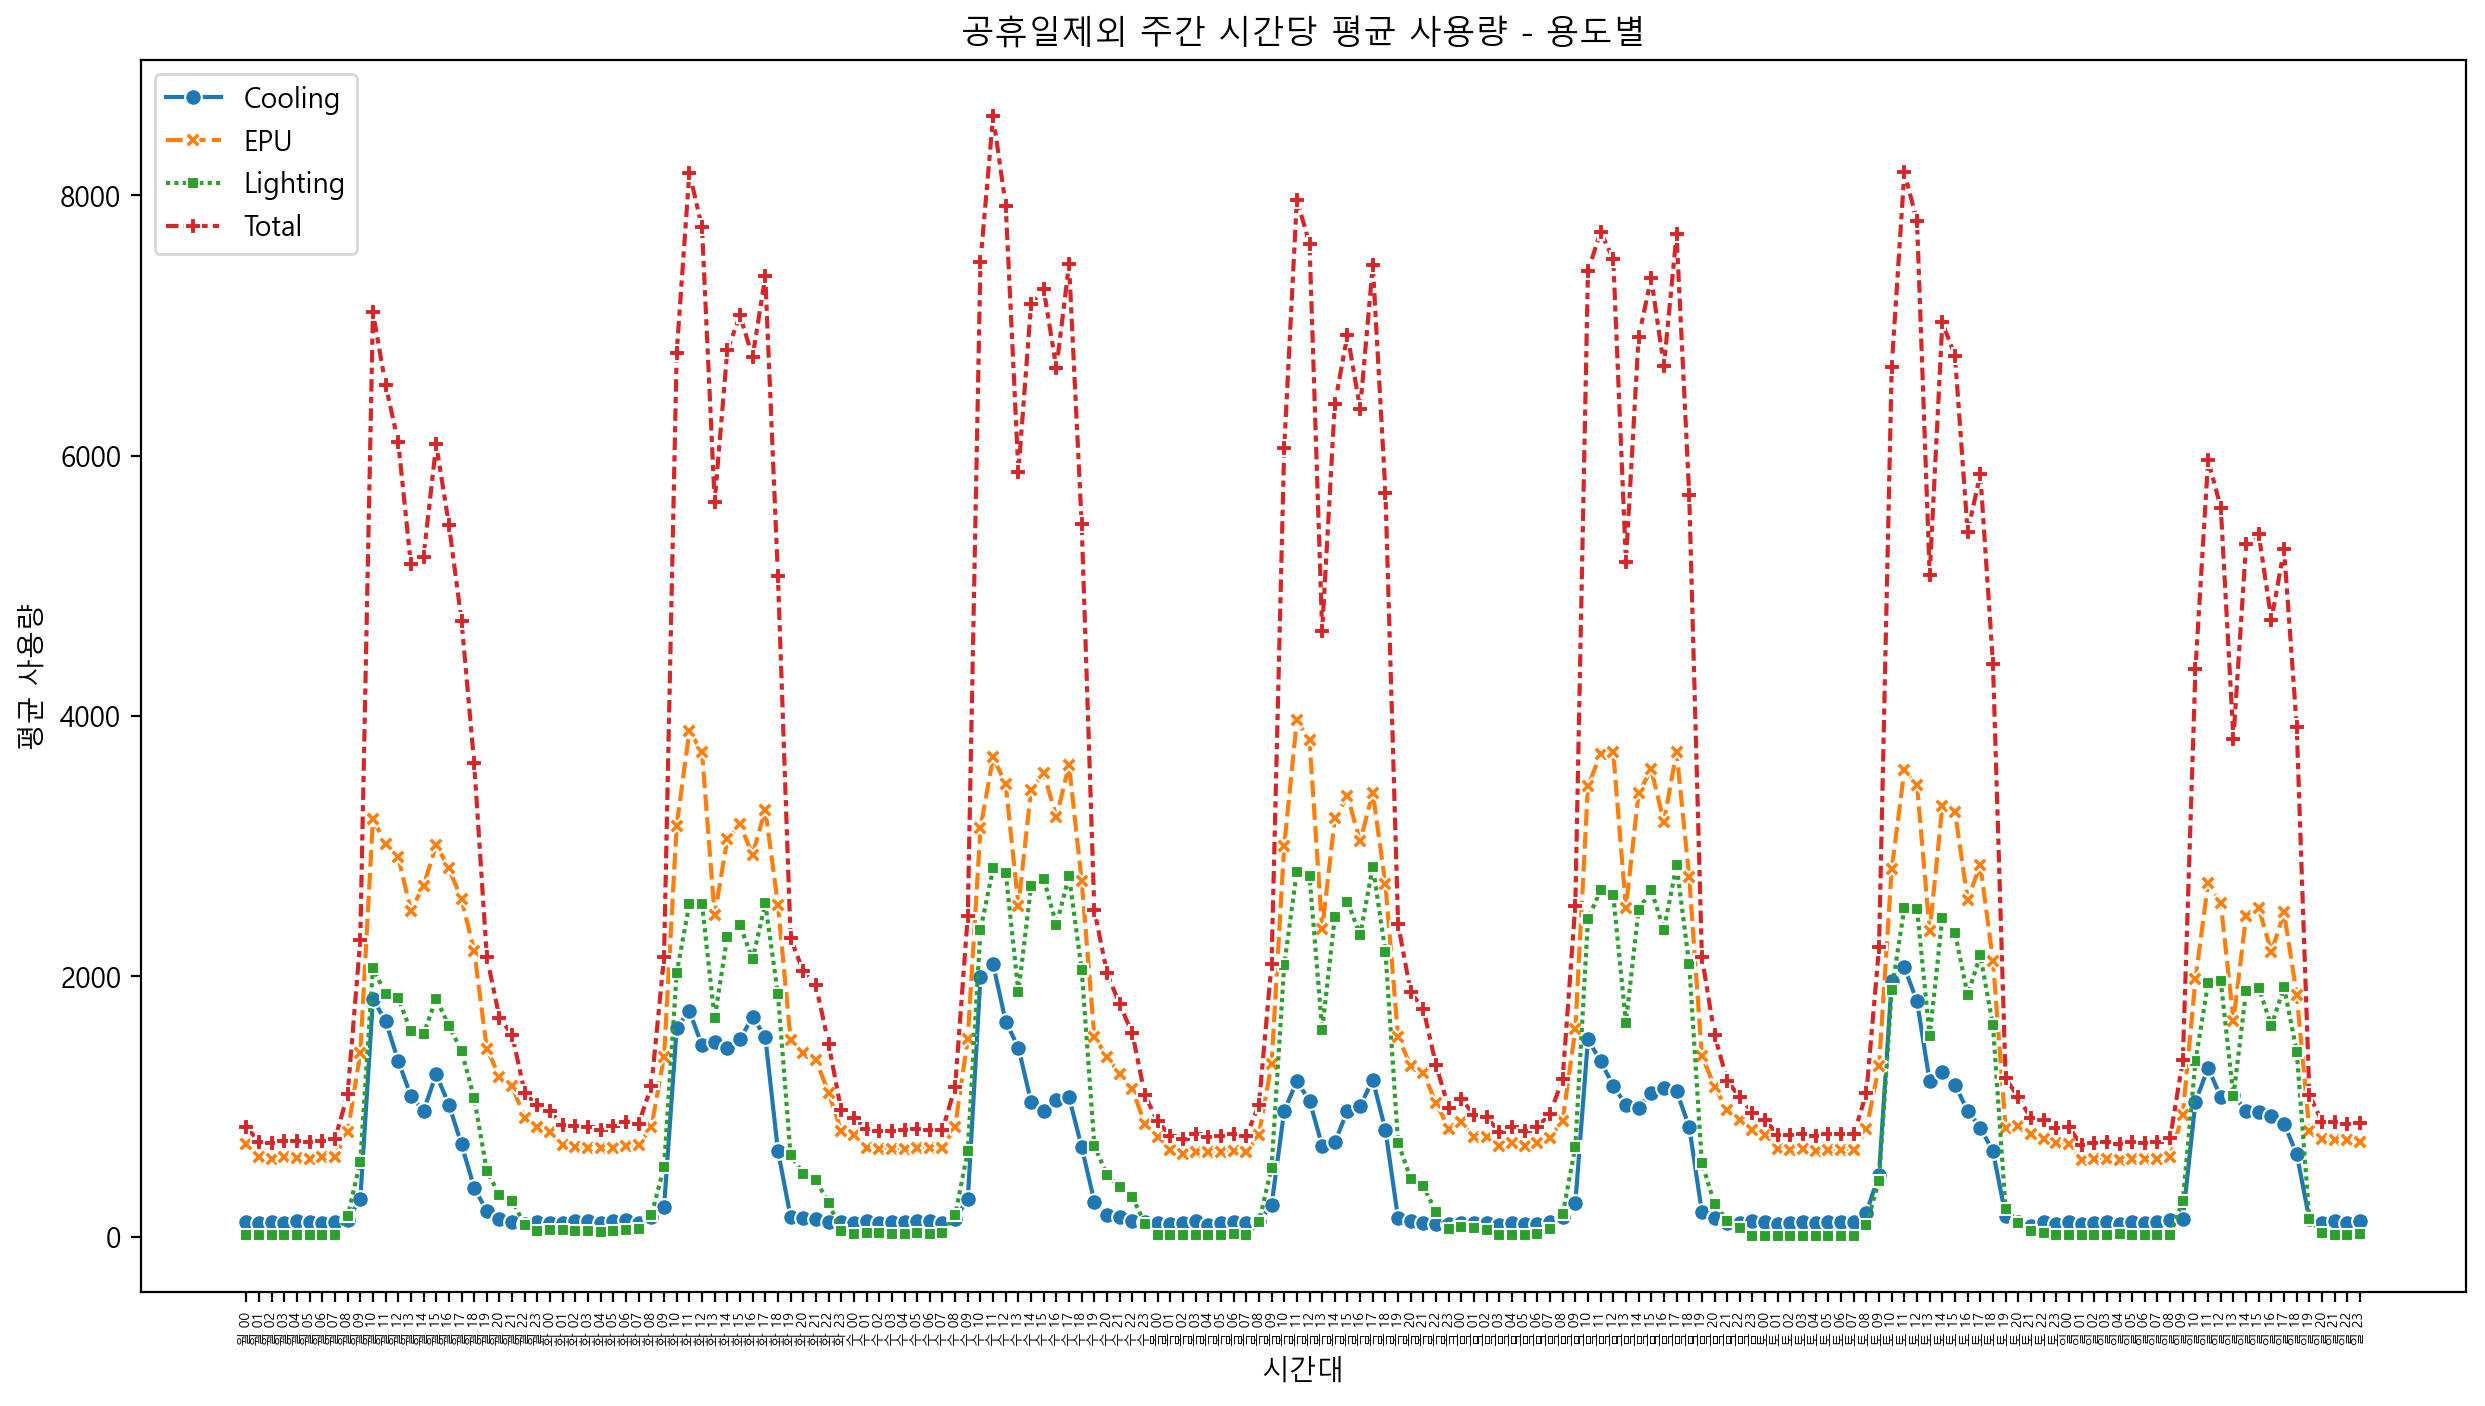

In [101]:
# 월요일부터 일요일까지 시간대별 용도별 평균값 계산
result = df_1hr[df_1hr.holiday == 0].groupby(['weekday', 'hour', 'useType'])['toeQty'].mean().reset_index()

weekday_list = ['월', '화', '수', '목', '금', '토', '일']

# 시각화
plt.figure(figsize=(15, 8))

# x축을 요일과 시간대로 설정
x_labels = [f'{weekday_list[day]} {hour:02d}' for day, hour in zip(result['weekday'], result['hour'])]
sns.lineplot(data=result, x=x_labels, y='toeQty', hue='useType', markers=True, style='useType')

# 그래프 제목 설정
plt.title('공휴일제외 주간 시간당 평균 사용량 - 용도별')

# x축과 y축 레이블 설정
plt.xlabel('시간대')
plt.ylabel('평균 사용량')

# 범례 위치 설정
plt.legend(loc='upper left')

# x축 레이블 각도 조정
plt.xticks(rotation=90, fontsize=5)

plt.show()

### 일간

#### 휴일포함

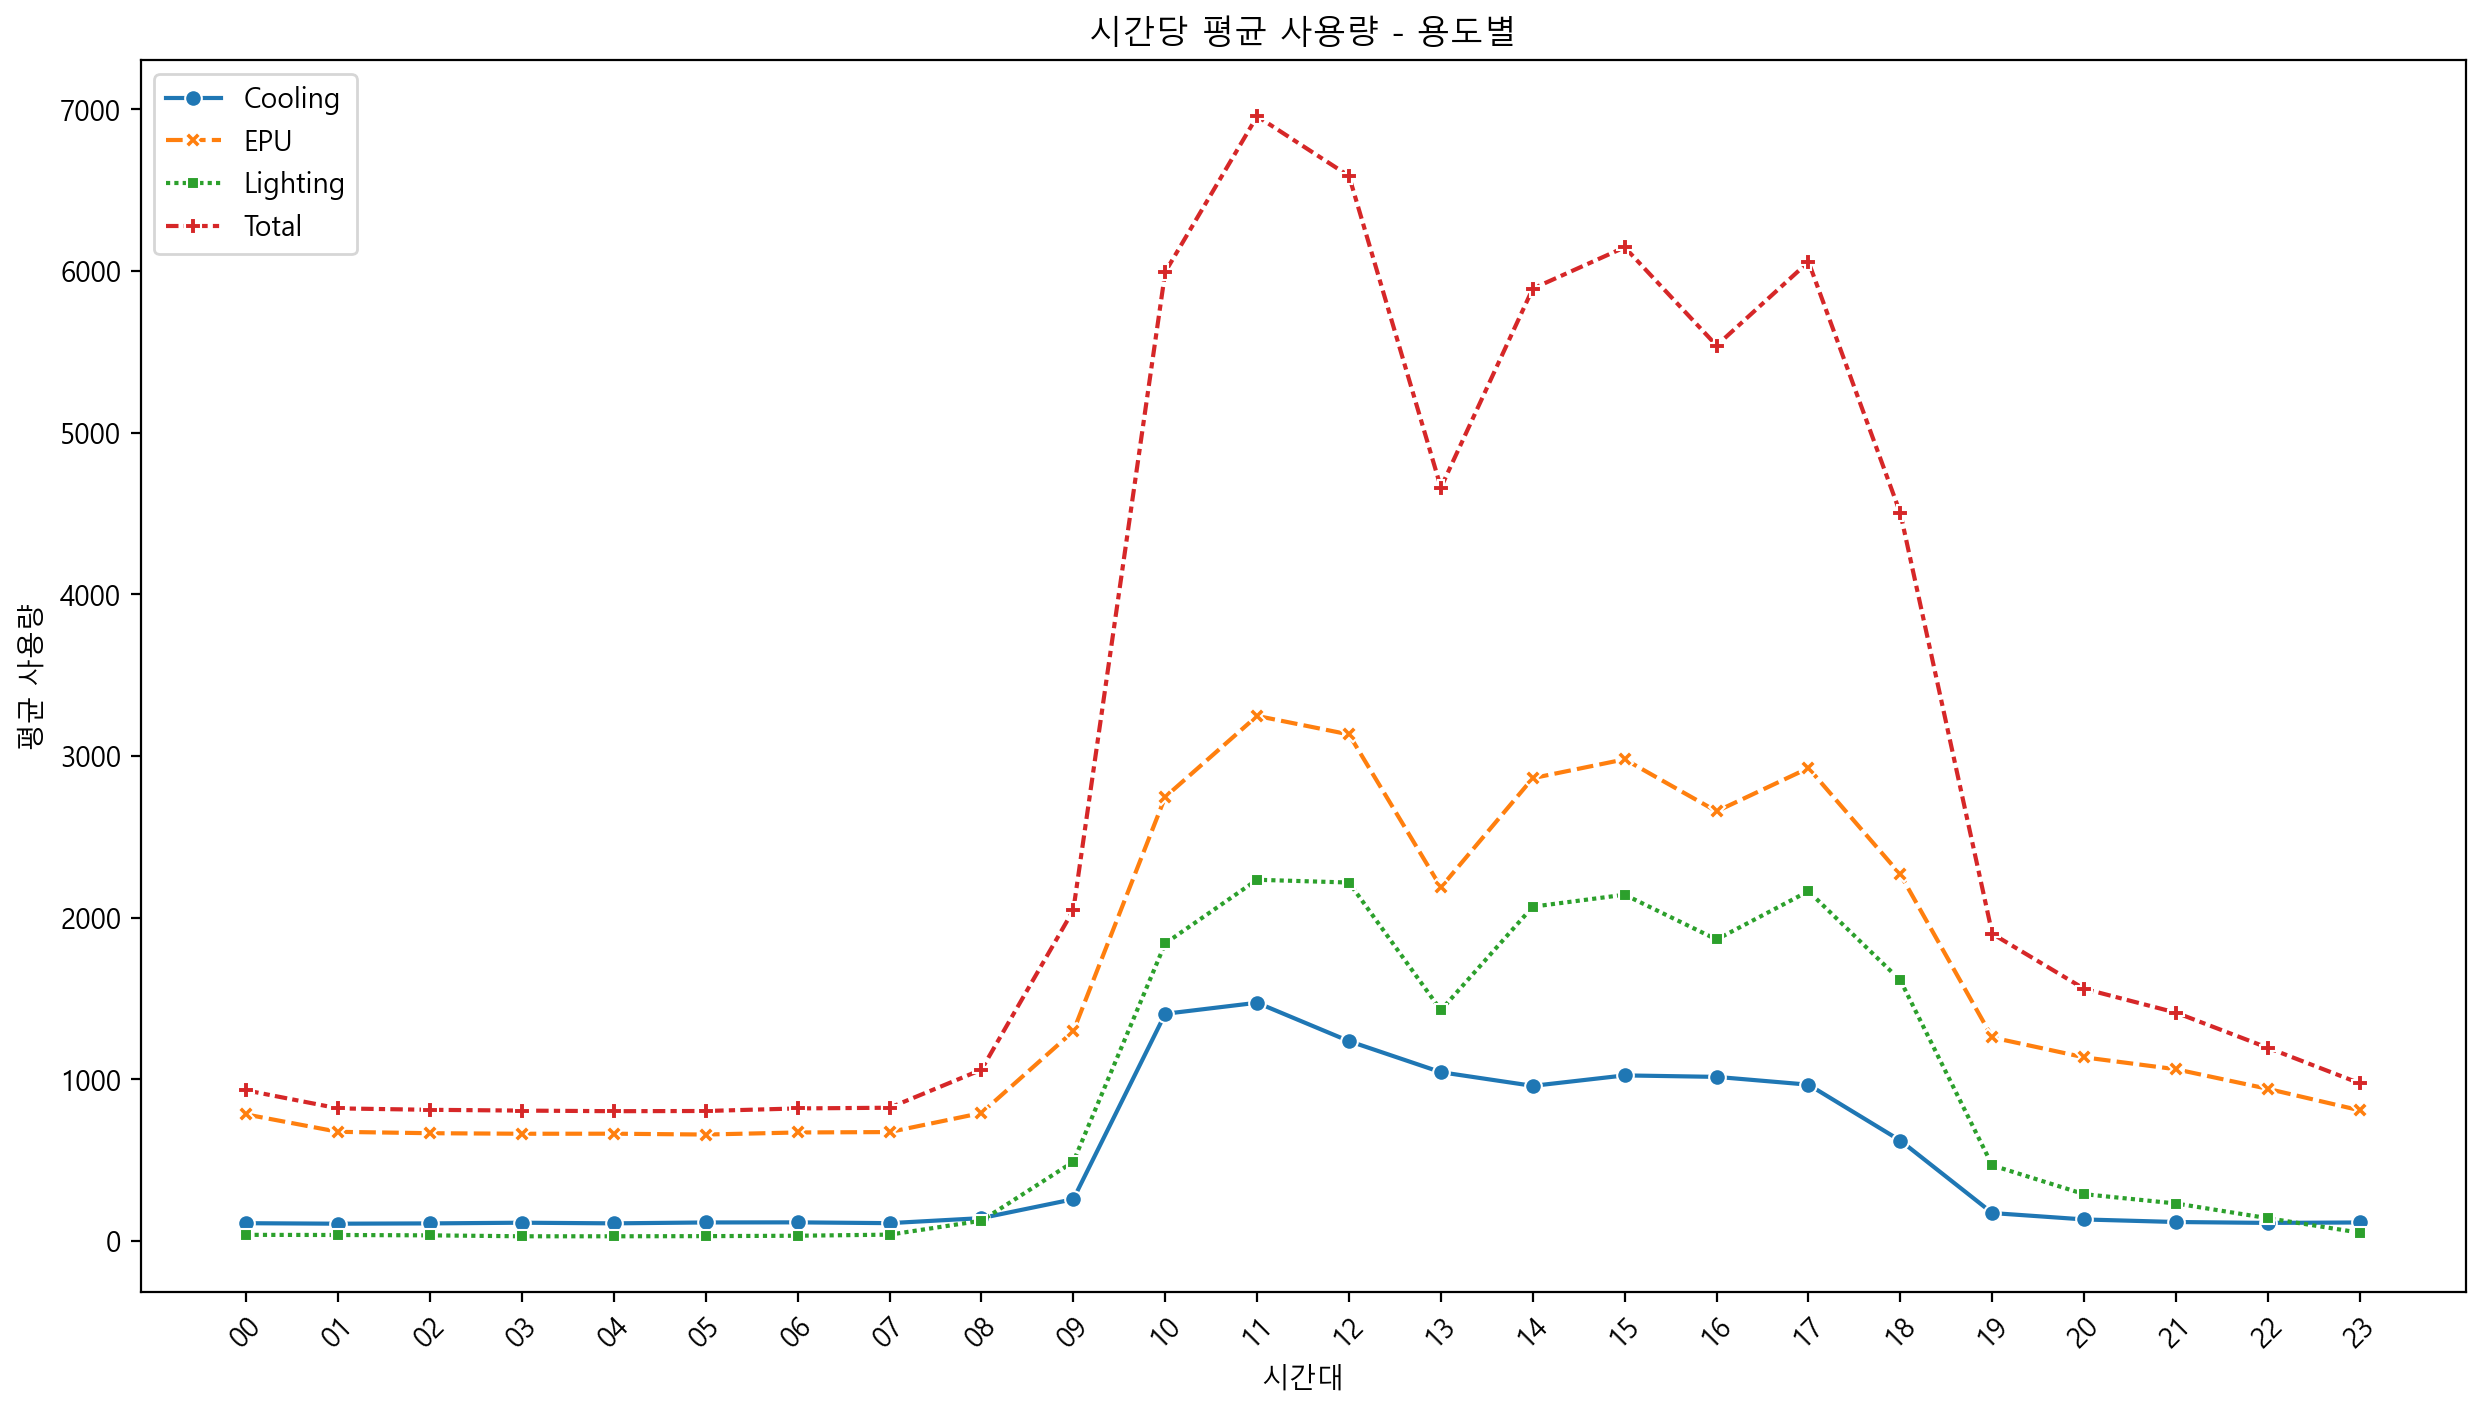

In [104]:
# 월요일부터 일요일까지 시간대별 용도별 평균값 계산
result = df_1hr.groupby(['hour', 'useType'])['toeQty'].mean().reset_index()

# 시각화
plt.figure(figsize=(15, 8))

# x축을 요일과 시간대로 설정
x_labels = [f'{hour:02d}' for  hour in  result['hour']]
sns.lineplot(data=result, x=x_labels, y='toeQty', hue='useType', markers=True, style='useType')

# 그래프 제목 설정
plt.title('시간당 평균 사용량 - 용도별')

# x축과 y축 레이블 설정
plt.xlabel('시간대')
plt.ylabel('평균 사용량')

# 범례 위치 설정
plt.legend(loc='upper left')

# x축 레이블 각도 조정
plt.xticks(rotation=45)

plt.show()

#### 휴일제외

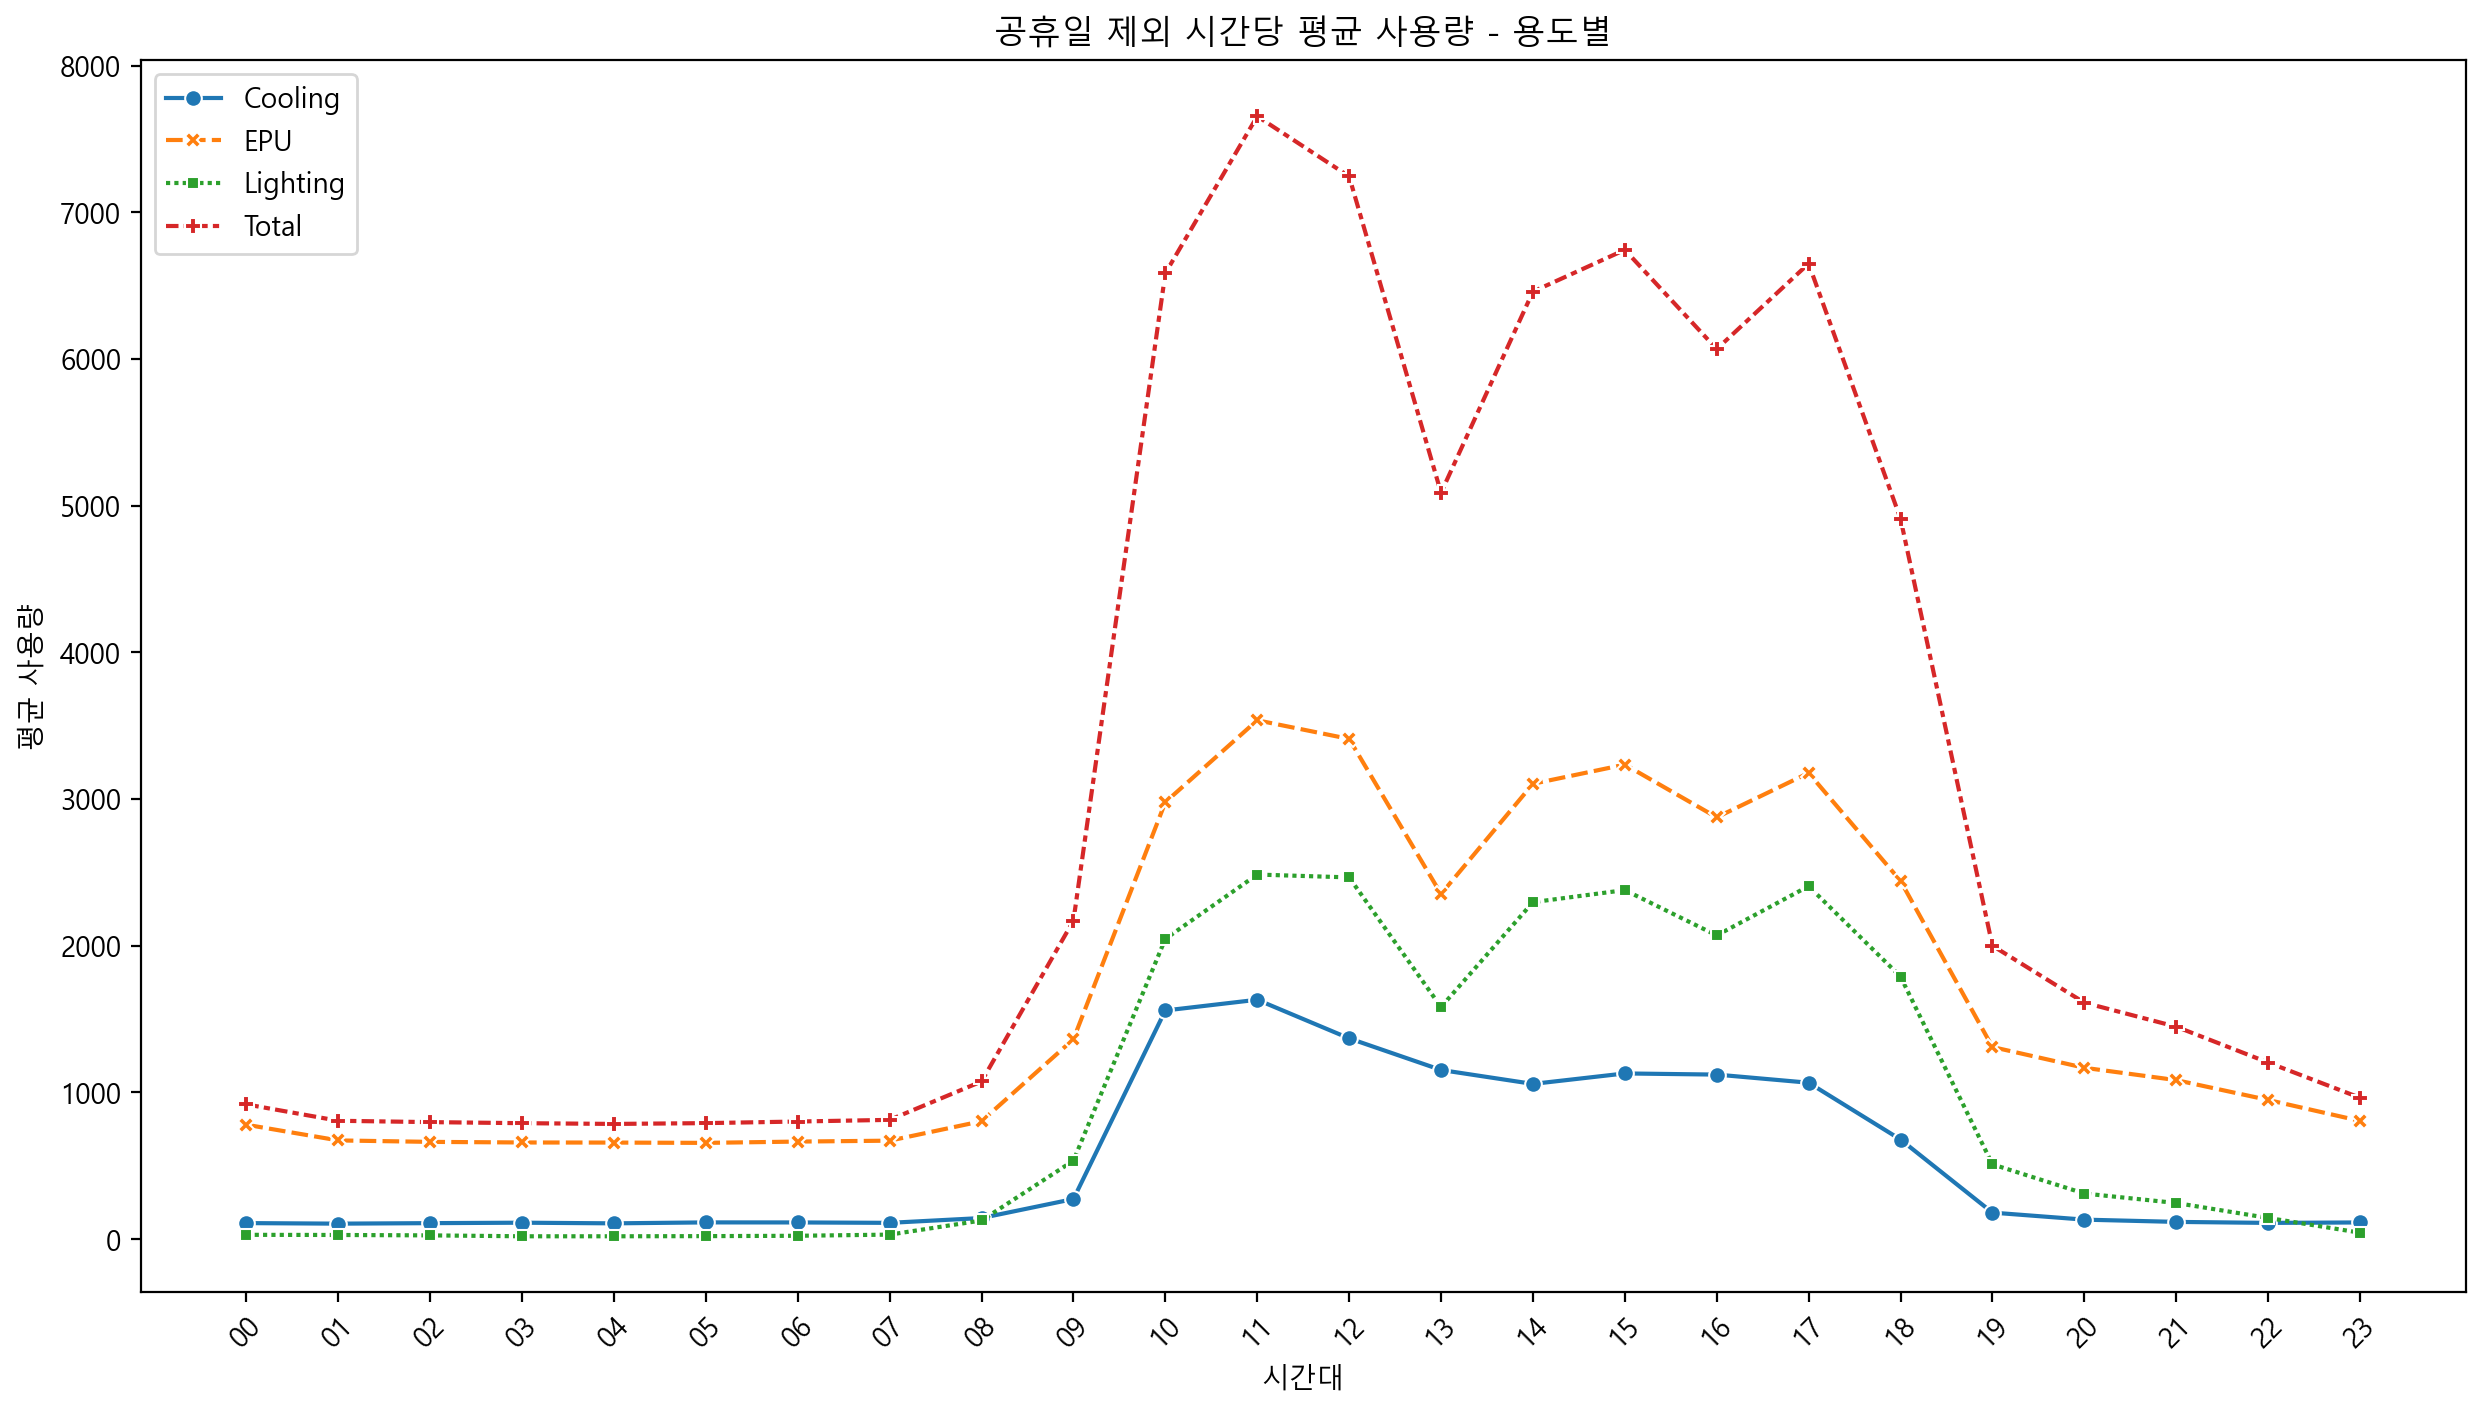

In [105]:
# 월요일부터 일요일까지 시간대별 용도별 평균값 계산
result = df_1hr[df_1hr.holiday == 0].groupby(['hour', 'useType'])['toeQty'].mean().reset_index()

# 시각화
plt.figure(figsize=(15, 8))

# x축을 요일과 시간대로 설정
x_labels = [f'{hour:02d}' for  hour in  result['hour']]
sns.lineplot(data=result, x=x_labels, y='toeQty', hue='useType', markers=True, style='useType')

# 그래프 제목 설정
plt.title('공휴일 제외 시간당 평균 사용량 - 용도별')

# x축과 y축 레이블 설정
plt.xlabel('시간대')
plt.ylabel('평균 사용량')

# 범례 위치 설정
plt.legend(loc='upper left')

# x축 레이블 각도 조정
plt.xticks(rotation=45)

plt.show()

In [106]:
# df_1hr = df_1hr[df_1hr.holiday == 0]

## 분포

### 전체

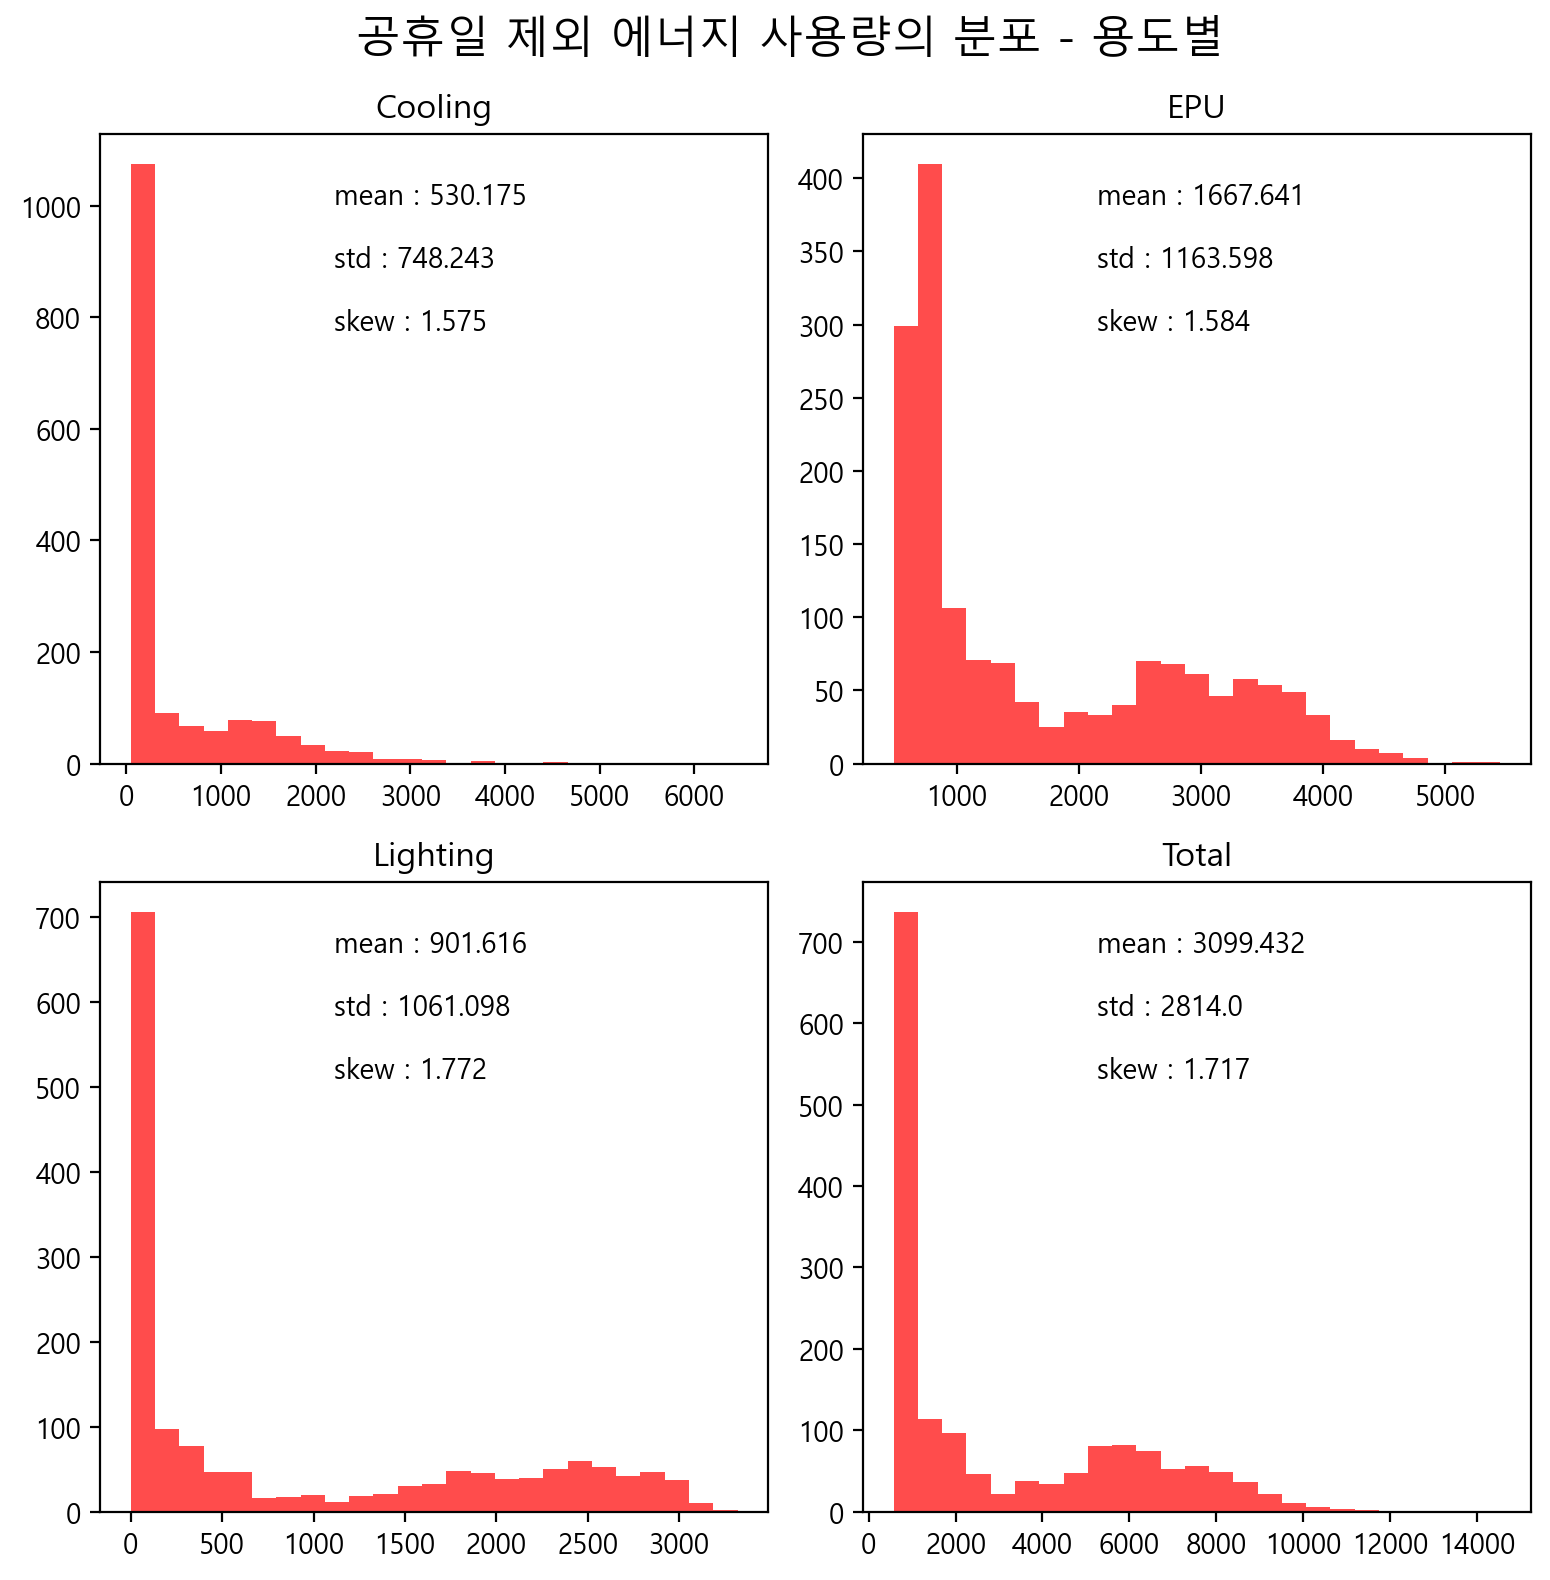

In [115]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))

useTypes = df_1hr['useType'].unique()

for i, ax in enumerate(axes.flatten()):
    if i < len(useTypes):
        useType = useTypes[i]
        df_useType = df_1hr[df_1hr['useType'] == useType]
        energy = df_useType['toeQty'].values
        mean = energy.mean().round(3)
        std = energy.std().round(3)
        skew = (3*(mean - np.median(energy))/energy.std()).round(3)
        ax.hist(energy, alpha = 0.7, bins = 25, color = 'red')
        ax.set_title(f'{useType}')
        ax.text(0.35, 0.9, f'mean : {mean}',  ha='left', va='center', transform=ax.transAxes)
        ax.text(0.35, 0.8, f'std : {std}',  ha='left', va='center', transform=ax.transAxes)
        ax.text(0.35, 0.7, f'skew : {skew}',  ha='left', va='center', transform=ax.transAxes)
        
fig.suptitle('공휴일 제외 에너지 사용량의 분포 - 용도별', fontsize=16)
plt.tight_layout()
plt.show()

### operating

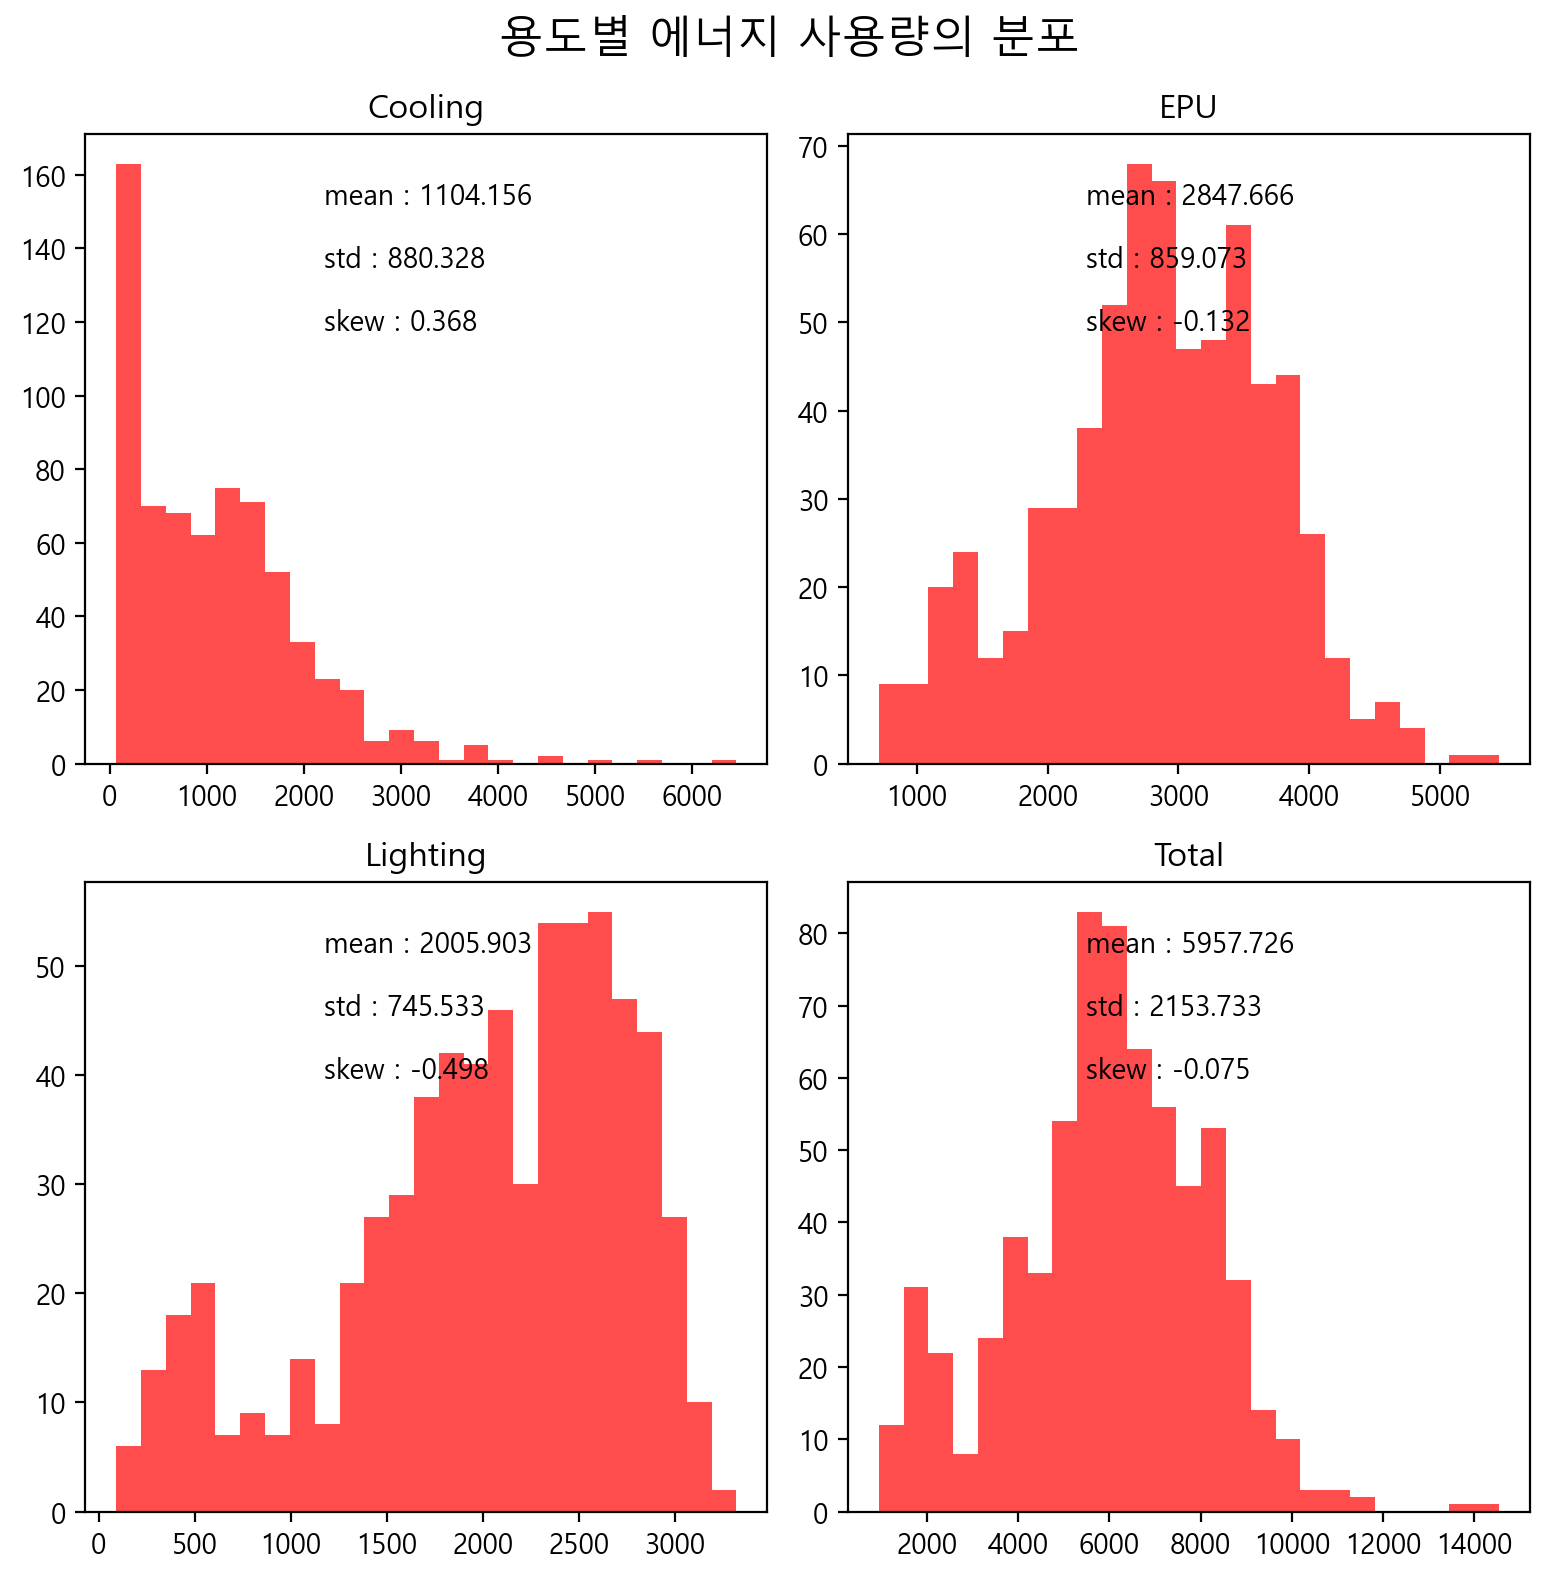

In [108]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))

useTypes = df_1hr['useType'].unique()

for i, ax in enumerate(axes.flatten()):
    if i < len(useTypes):
        useType = useTypes[i]
        df_useType = df_1hr[df_1hr.operating == 1][df_1hr['useType'] == useType]
        energy = df_useType['toeQty'].values
        mean = energy.mean().round(3)
        std = energy.std().round(3)
        skew = (3*(mean - np.median(energy))/energy.std()).round(3)
        ax.hist(energy, alpha = 0.7, bins = 25, color = 'red')
        ax.set_title(f'{useType}')
        ax.text(0.35, 0.9, f'mean : {mean}',  ha='left', va='center', transform=ax.transAxes)
        ax.text(0.35, 0.8, f'std : {std}',  ha='left', va='center', transform=ax.transAxes)
        ax.text(0.35, 0.7, f'skew : {skew}',  ha='left', va='center', transform=ax.transAxes)
        
fig.suptitle('용도별 에너지 사용량의 분포', fontsize=16)
plt.tight_layout()
plt.show()

### not operating

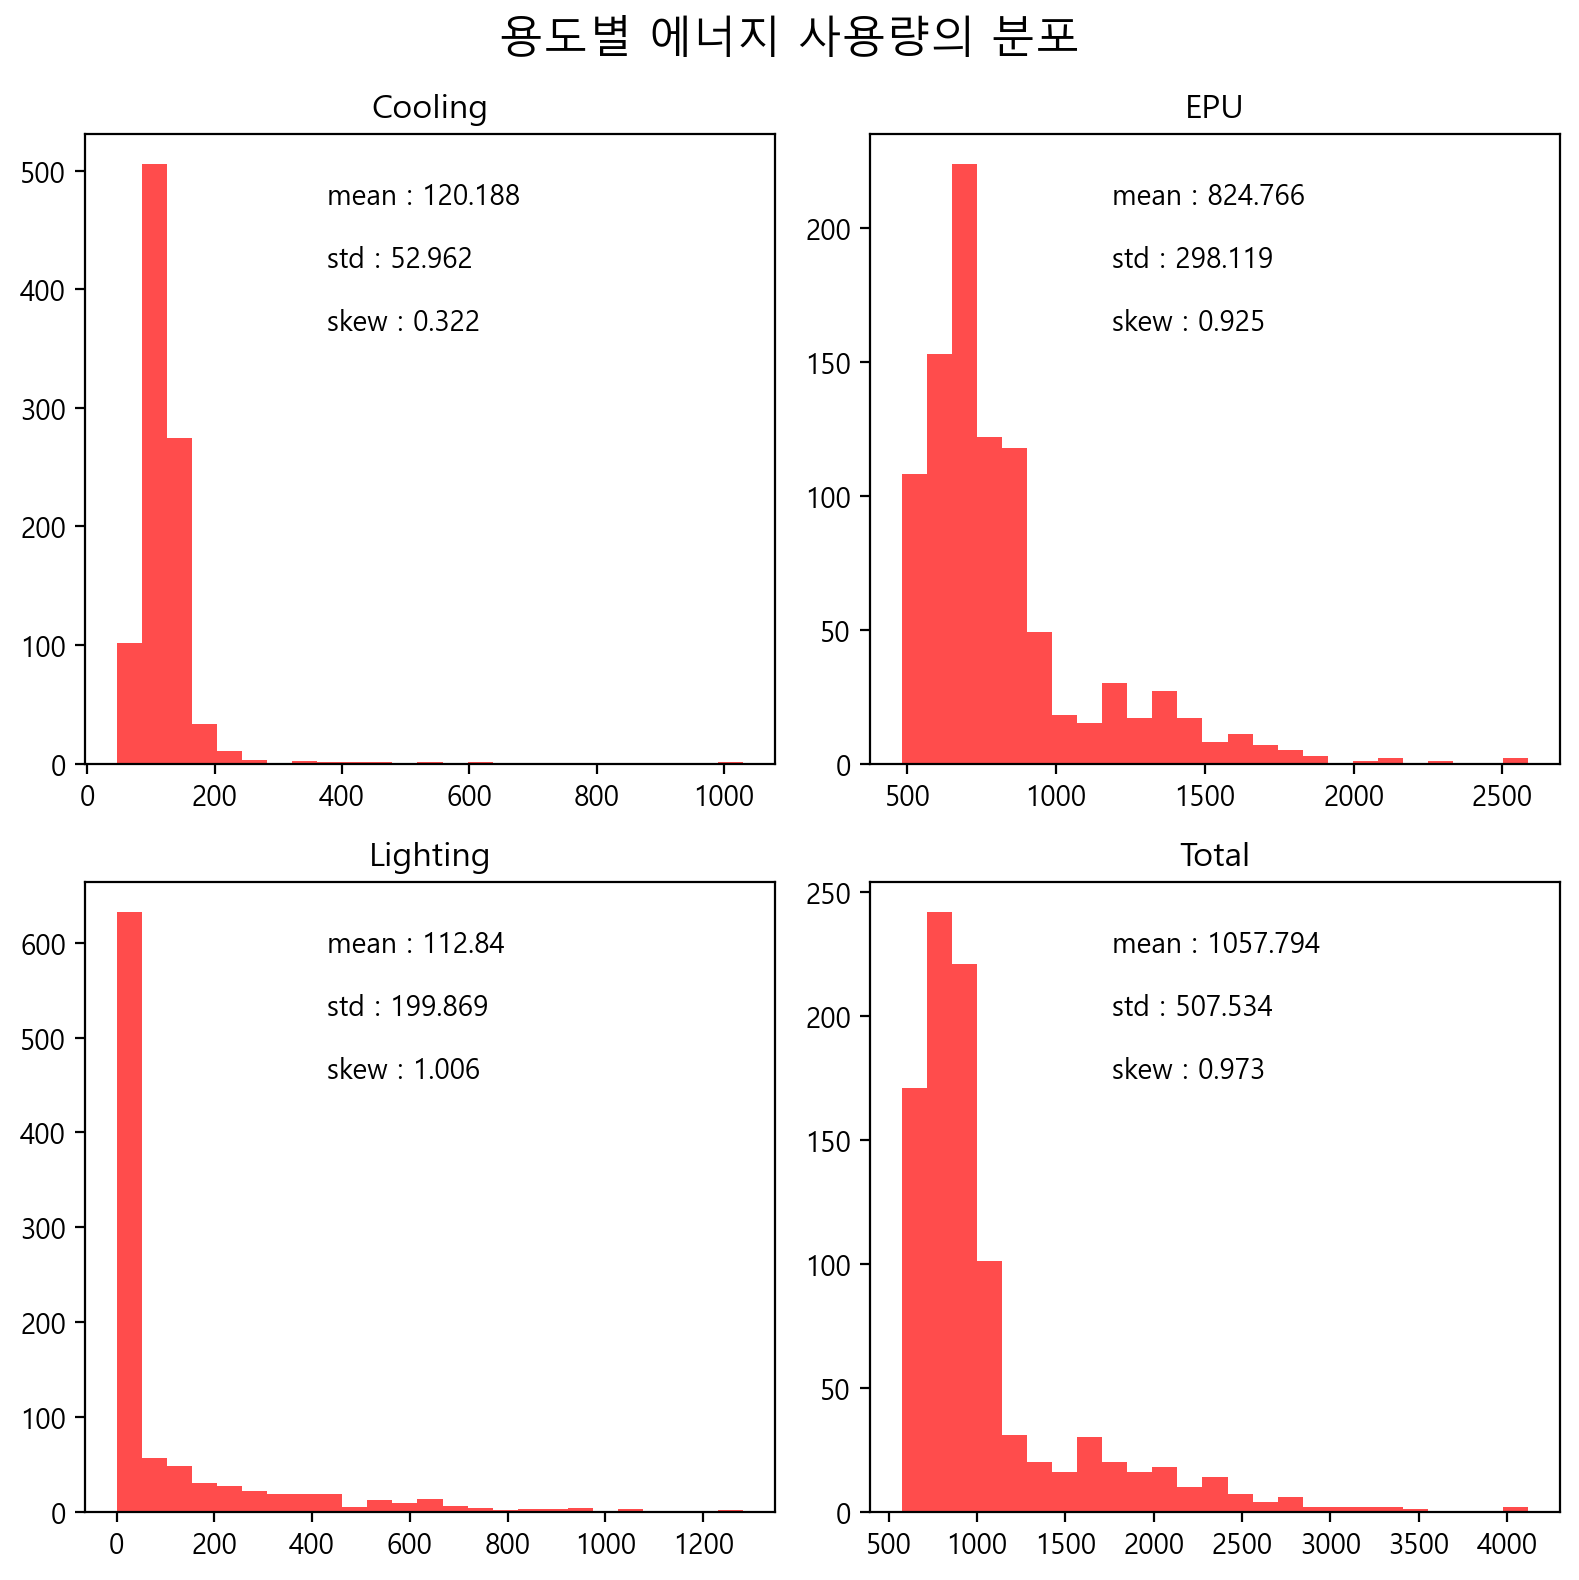

In [109]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))

useTypes = df_1hr['useType'].unique()

for i, ax in enumerate(axes.flatten()):
    if i < len(useTypes):
        useType = useTypes[i]
        df_useType = df_1hr[df_1hr.operating == 0][df_1hr['useType'] == useType]
        energy = df_useType['toeQty'].values
        mean = energy.mean().round(3)
        std = energy.std().round(3)
        skew = (3*(mean - np.median(energy))/energy.std()).round(3)
        ax.hist(energy, alpha = 0.7, bins = 25, color = 'red')
        ax.set_title(f'{useType}')
        ax.text(0.35, 0.9, f'mean : {mean}',  ha='left', va='center', transform=ax.transAxes)
        ax.text(0.35, 0.8, f'std : {std}',  ha='left', va='center', transform=ax.transAxes)
        ax.text(0.35, 0.7, f'skew : {skew}',  ha='left', va='center', transform=ax.transAxes)
        
fig.suptitle('용도별 에너지 사용량의 분포', fontsize=16)
plt.tight_layout()
plt.show()

### l2

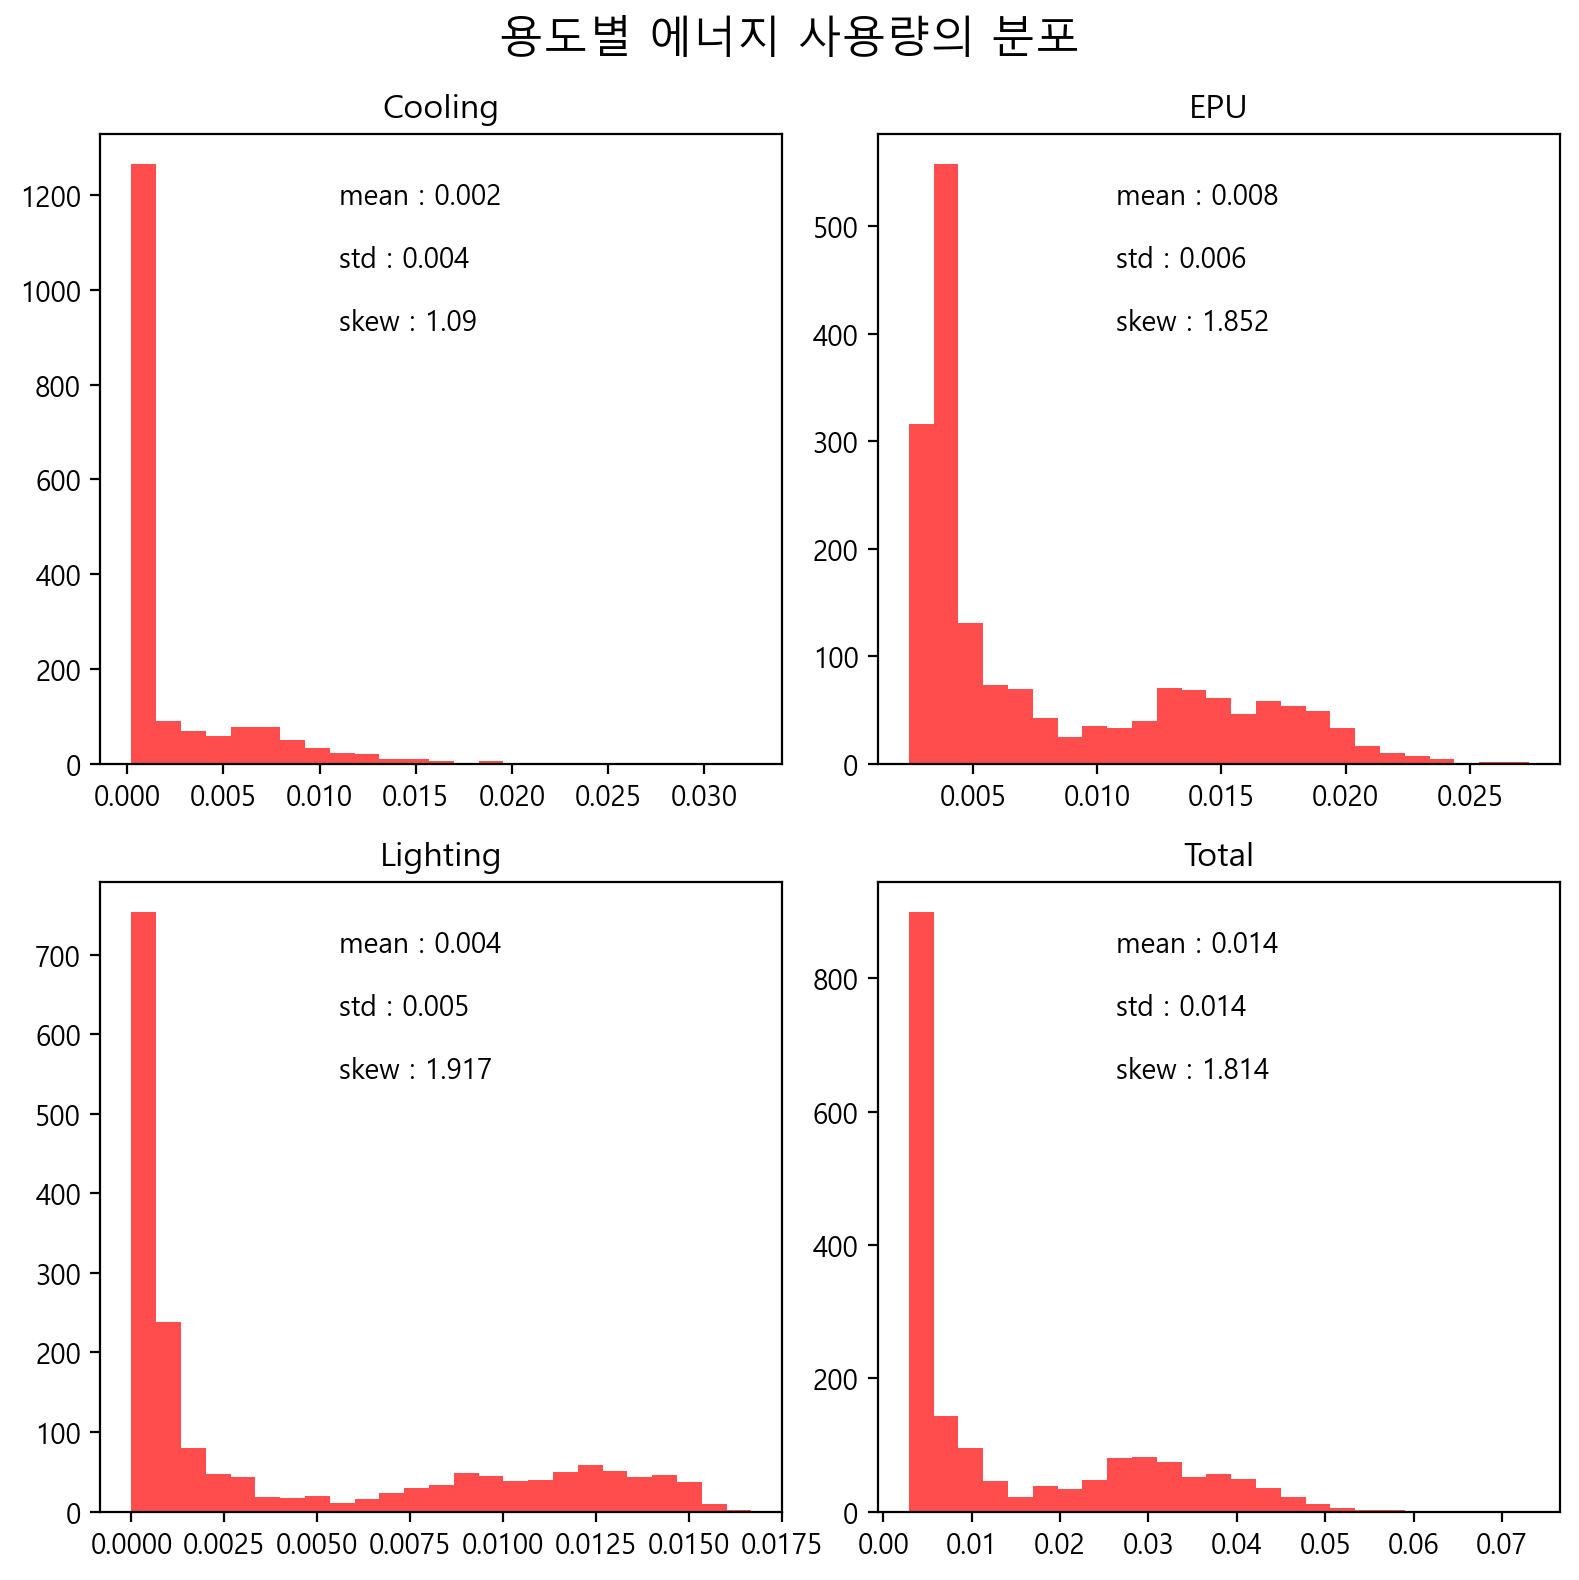

In [111]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))

useTypes = df_1hr_l2['useType'].unique()

for i, ax in enumerate(axes.flatten()):
    if i < len(useTypes):
        useType = useTypes[i]
        df_useType = df_1hr_l2[df_1hr_l2['useType'] == useType]
        energy = df_useType['toeQty'].values
        mean = energy.mean().round(3)
        std = energy.std().round(3)
        skew = (3*(mean - np.median(energy))/energy.std()).round(3)
        ax.hist(energy, alpha = 0.7, bins = 25, color = 'red')
        ax.set_title(f'{useType}')
        ax.text(0.35, 0.9, f'mean : {mean}',  ha='left', va='center', transform=ax.transAxes)
        ax.text(0.35, 0.8, f'std : {std}',  ha='left', va='center', transform=ax.transAxes)
        ax.text(0.35, 0.7, f'skew : {skew}',  ha='left', va='center', transform=ax.transAxes)
        
fig.suptitle('용도별 에너지 사용량의 분포', fontsize=16)
plt.tight_layout()
plt.show()

## 요일별 히트맵

### 전체

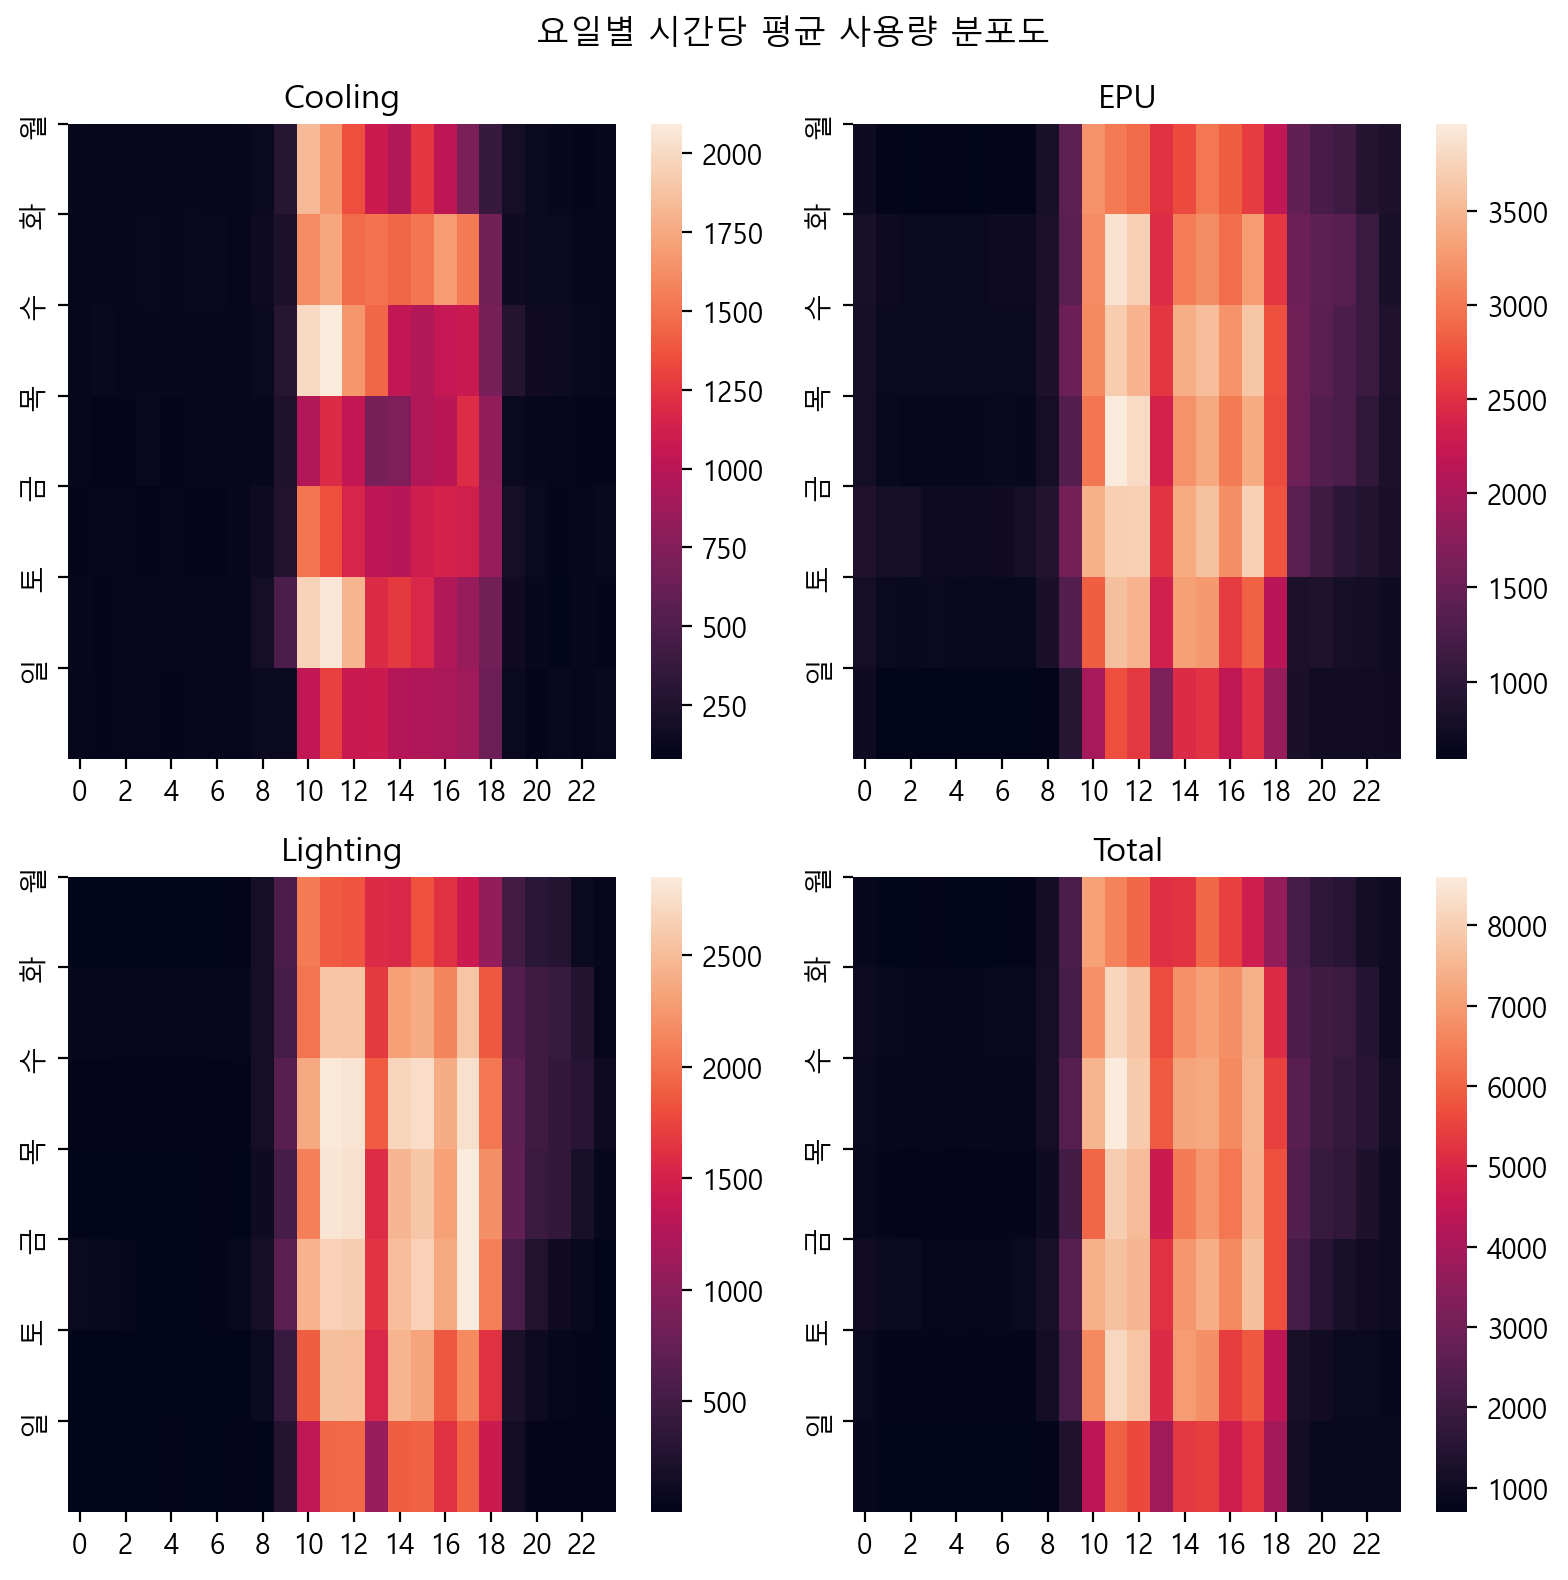

In [112]:
fig = plt.figure(figsize=(8, 8))
useTypes = df_1hr['useType'].unique()
weekday_list = ['월', '화', '수', '목', '금', '토', '일']
for idx, useType in enumerate(useTypes):
    df_useType = df_1hr[df_1hr['useType'] == useType]

    df_pivot = df_useType.pivot_table(index='weekday', columns='hour', values='toeQty', aggfunc='mean')
    plt.subplot(2, 2, idx+1)
    sns.heatmap(df_pivot)
    plt.title(f'{useType}')
    plt.xlabel('')
    plt.ylabel('')
    plt.yticks(range(7), weekday_list)
     
fig.suptitle('요일별 시간당 평균 사용량 분포도')        
plt.tight_layout()
plt.show()

### operating

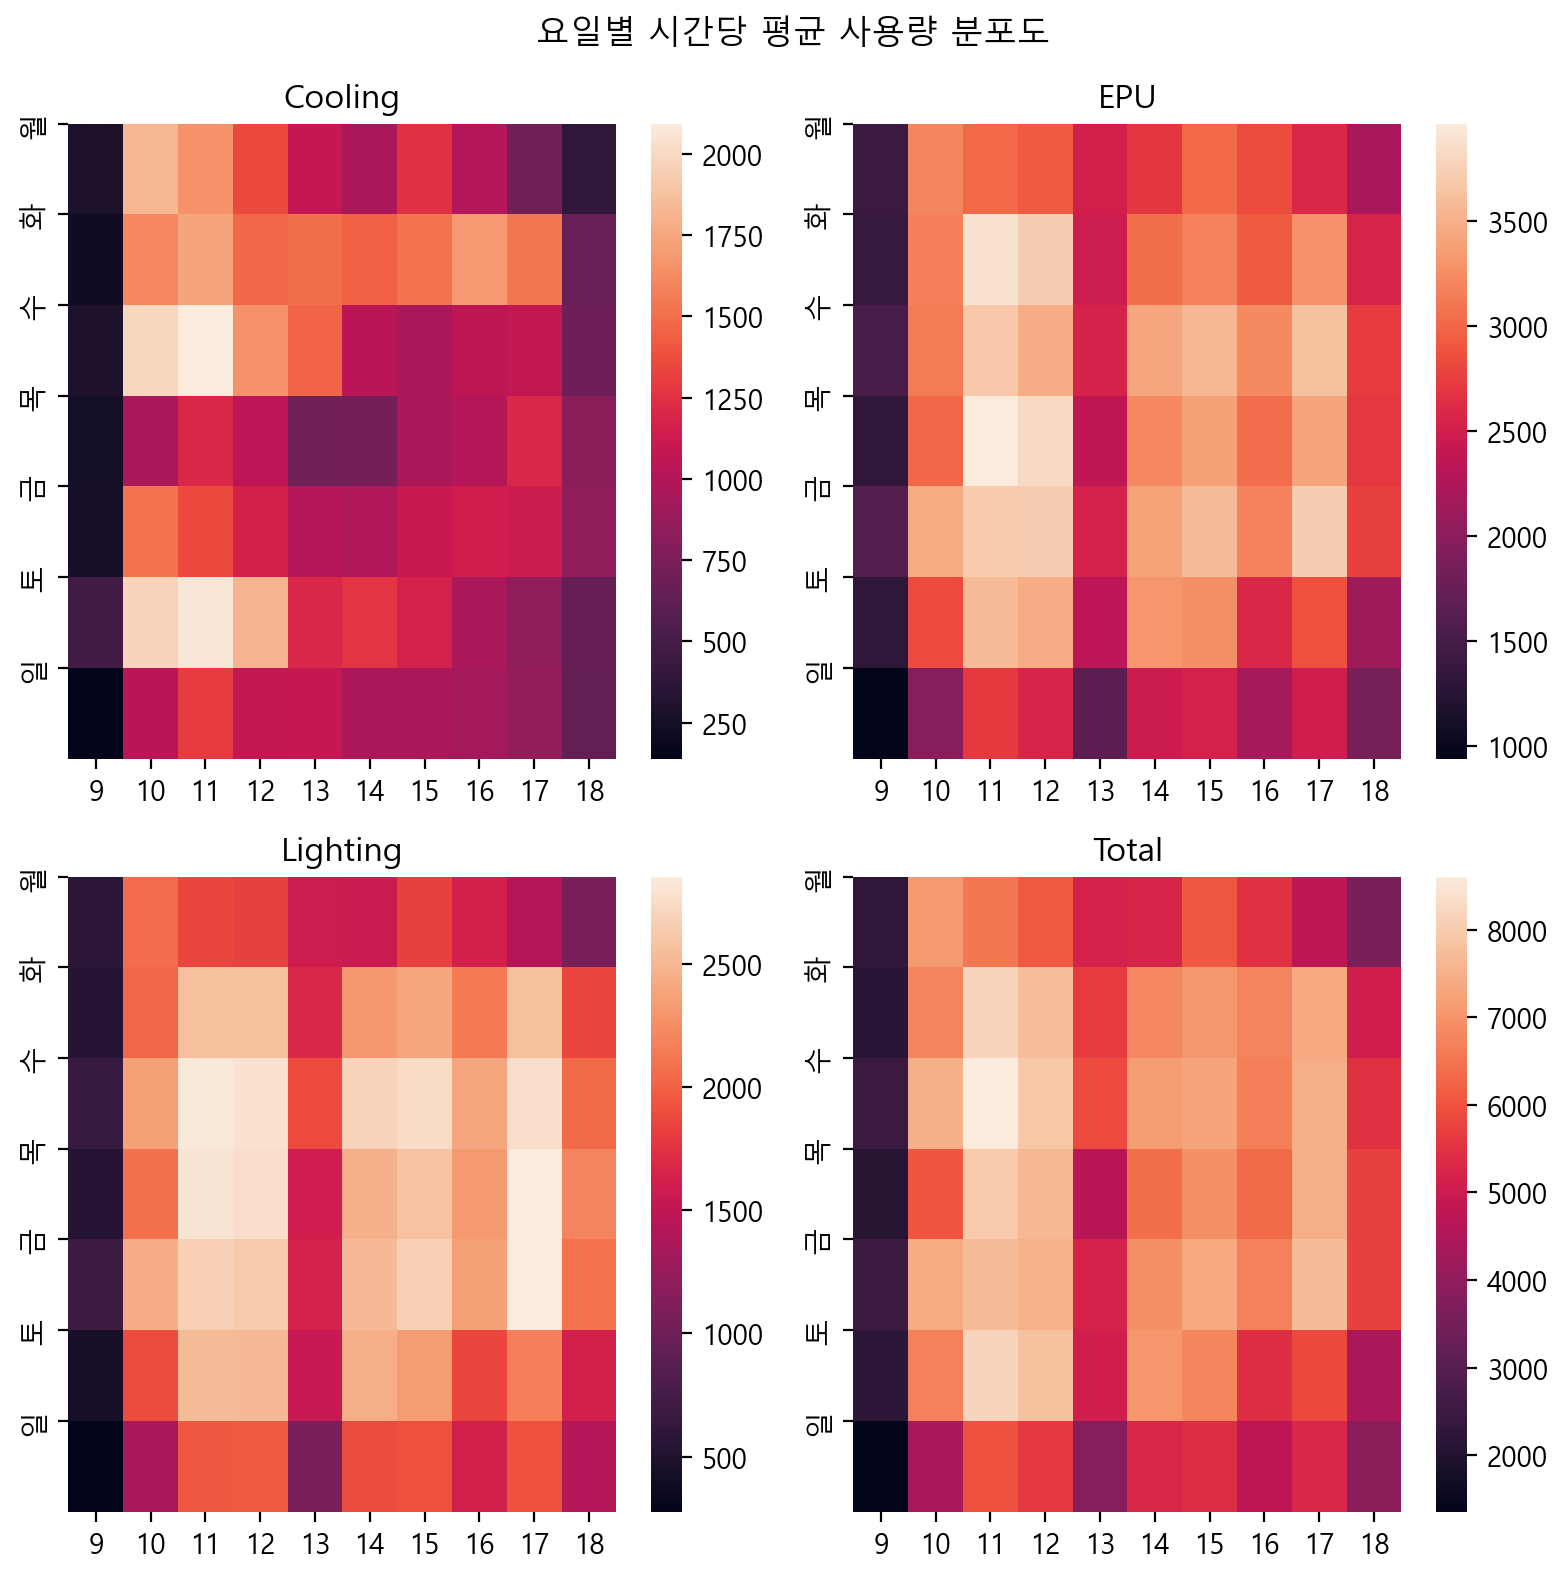

In [113]:
fig = plt.figure(figsize=(8, 8))
useTypes = df_1hr[df_1hr.operating == 1]['useType'].unique()
weekday_list = ['월', '화', '수', '목', '금', '토', '일']
for idx, useType in enumerate(useTypes):
    df_useType = df_1hr[df_1hr.operating == 1][df_1hr['useType'] == useType]

    df_pivot = df_useType.pivot_table(index='weekday', columns='hour', values='toeQty', aggfunc='mean')
    plt.subplot(2, 2, idx+1)
    sns.heatmap(df_pivot)
    plt.title(f'{useType}')
    plt.xlabel('')
    plt.ylabel('')
    plt.yticks(range(7), weekday_list)
     
fig.suptitle('요일별 시간당 평균 사용량 분포도')        
plt.tight_layout()
plt.show()

### not operating

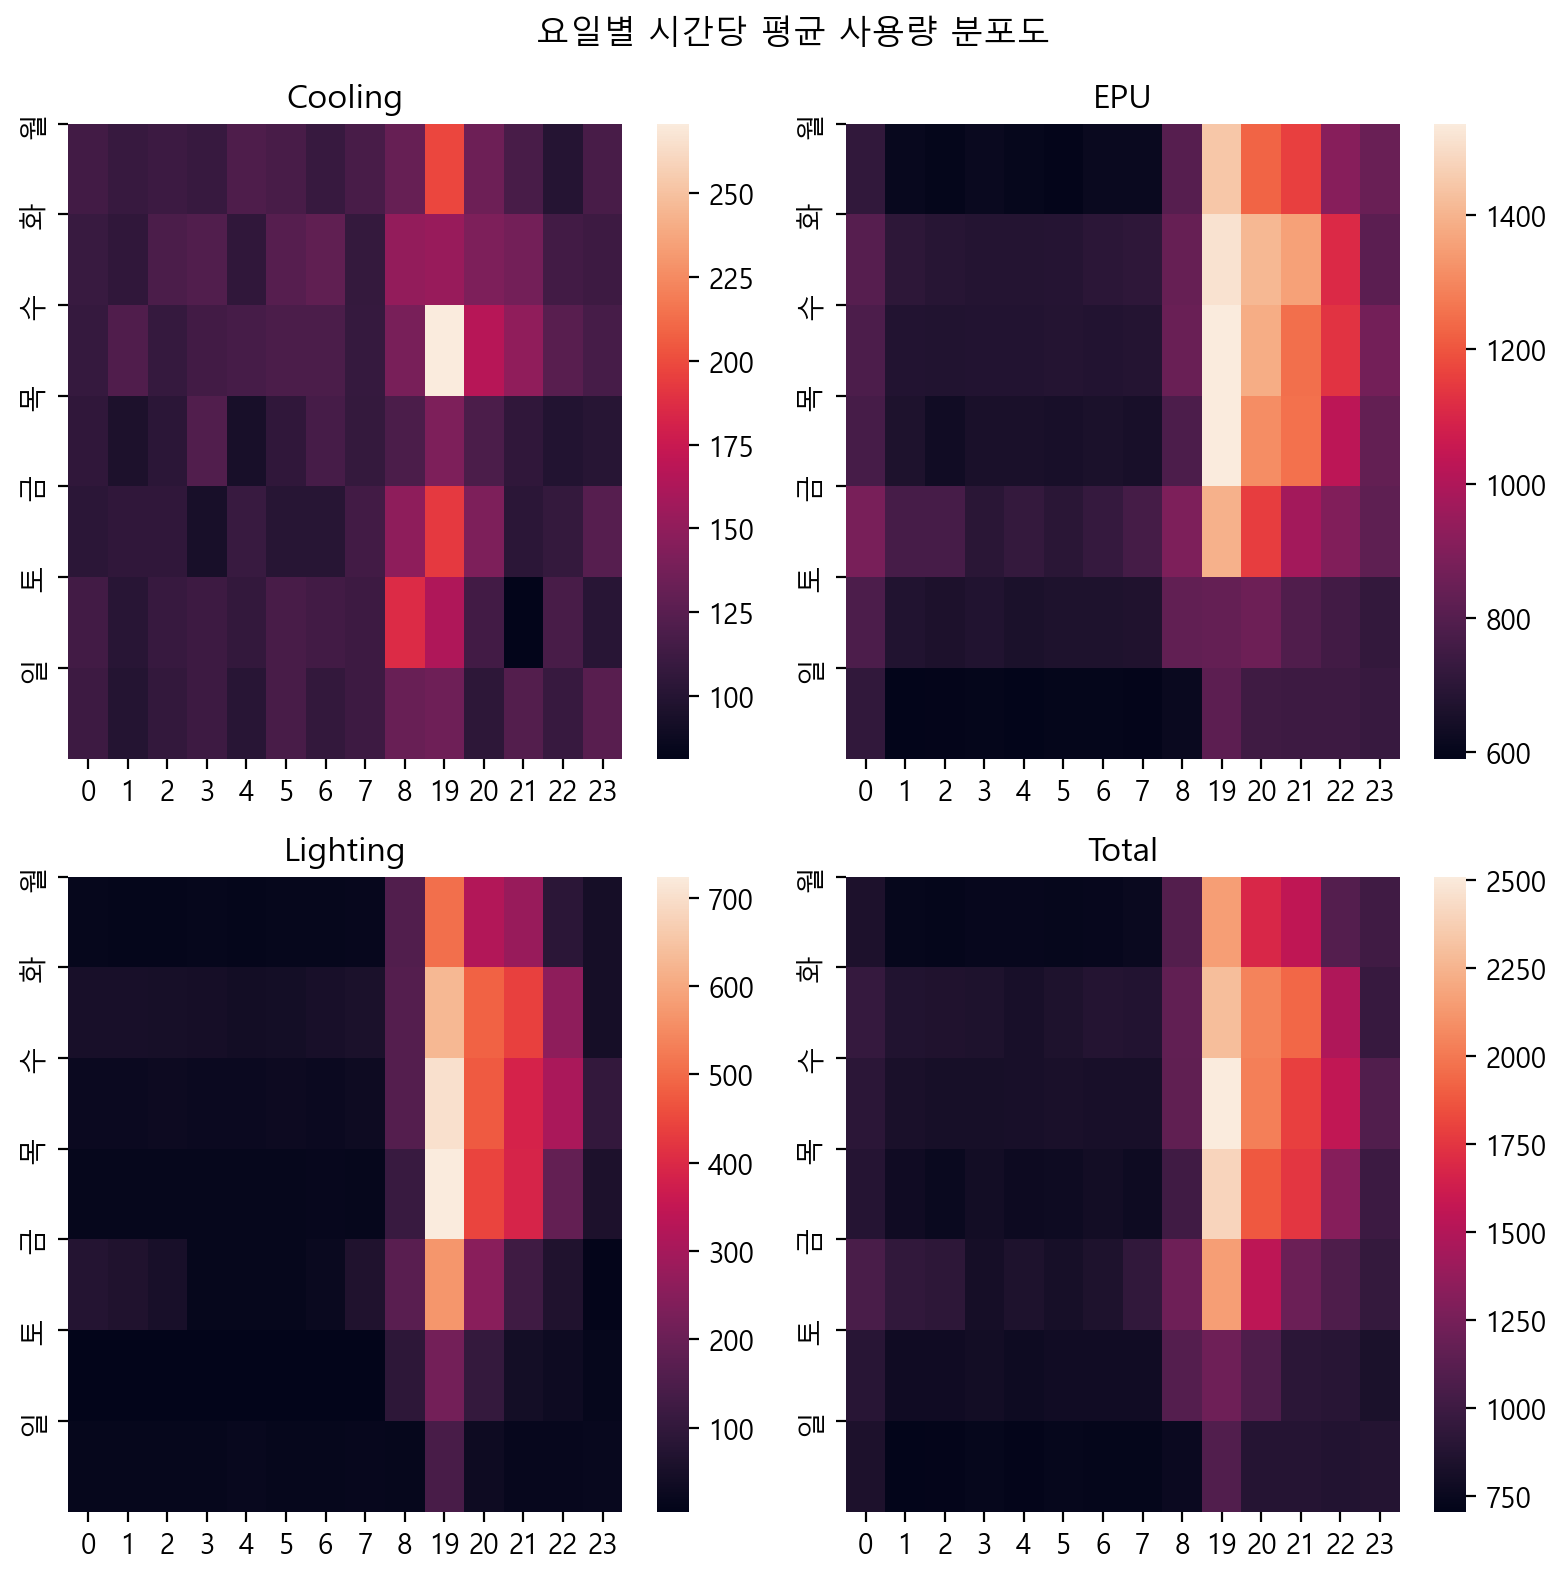

In [114]:
fig = plt.figure(figsize=(8, 8))
useTypes = df_1hr[df_1hr.operating == 0]['useType'].unique()
weekday_list = ['월', '화', '수', '목', '금', '토', '일']
for idx, useType in enumerate(useTypes):
    df_useType = df_1hr[df_1hr.operating == 0][df_1hr['useType'] == useType]

    df_pivot = df_useType.pivot_table(index='weekday', columns='hour', values='toeQty', aggfunc='mean')
    plt.subplot(2, 2, idx+1)
    sns.heatmap(df_pivot)
    plt.title(f'{useType}')
    plt.xlabel('')
    plt.ylabel('')
    plt.yticks(range(7), weekday_list)
     
fig.suptitle('요일별 시간당 평균 사용량 분포도')        
plt.tight_layout()
plt.show()

* train, test data 분리
* train_df 는 2023-08-07 월요일 ~ 2023-10-15 일요일 데이터
* test_df 는 그 이외인 2023-08-06 일요일 이전 데이터와 2023-10-16 월요일 이후 데이터

In [84]:
# train_df = df_1hr[('2023-08-14 00:00:00.000'<= df_1hr['useDate']) & (df_1hr['useDate'] < '2023-10-16 00:00:00.000')]
# test_df = df_1hr[('2023-08-14 00:00:00.000' > df_1hr['useDate']) | (df_1hr['useDate'] >= '2023-10-16 00:00:00.000')]
# train_df.to_csv('data/train_df.csv')
# test_df.to_csv('data/test_df.csv')

# Derived Variable

In [85]:
df_1hr_dv = df_1hr.copy()

## 시간변수 - hour fourier transform

In [86]:
from scipy.optimize import minimize

data = df_1hr_dv[df_1hr_dv['useType'] == 'Total'].groupby(['hour'])['toeQty'].mean().reset_index(drop=True).values

def periodic_function(params, x):
    A, B, frequency, phase = params
    return A + B * np.cos(2 * np.pi * frequency * (x - phase))

def objective_function(params):
    predicted_data = periodic_function(params, np.arange(24))
    correlation = np.corrcoef(data, predicted_data)[0, 1]
    return -correlation 

initial_params = [min(data), max(data), 1 / 24, 10.5]

result = minimize(objective_function, initial_params, method='Nelder-Mead')
optimized_params = result.x

optimized_function = lambda x: periodic_function(optimized_params, x)

hour = np.arange(0, 24, 1)

A, B, frequency, phase = optimized_params
frequency = 1/ 24

ft = A + (B - A) / 2 * np.cos(2 * np.pi * frequency * (hour - phase))

df_1hr_dv['ft'] = A + (B - A) / 2 * np.cos(2 * np.pi * frequency * (df_1hr_dv['hour'] - phase))

## THI - 불쾌지수

In [87]:
df_1hr_dv['THI'] = 9/5*df_1hr_dv['temp'] - 0.55*(1-df_1hr_dv['hum']/100)*(9/5*df_1hr_dv['temp']-26)+32

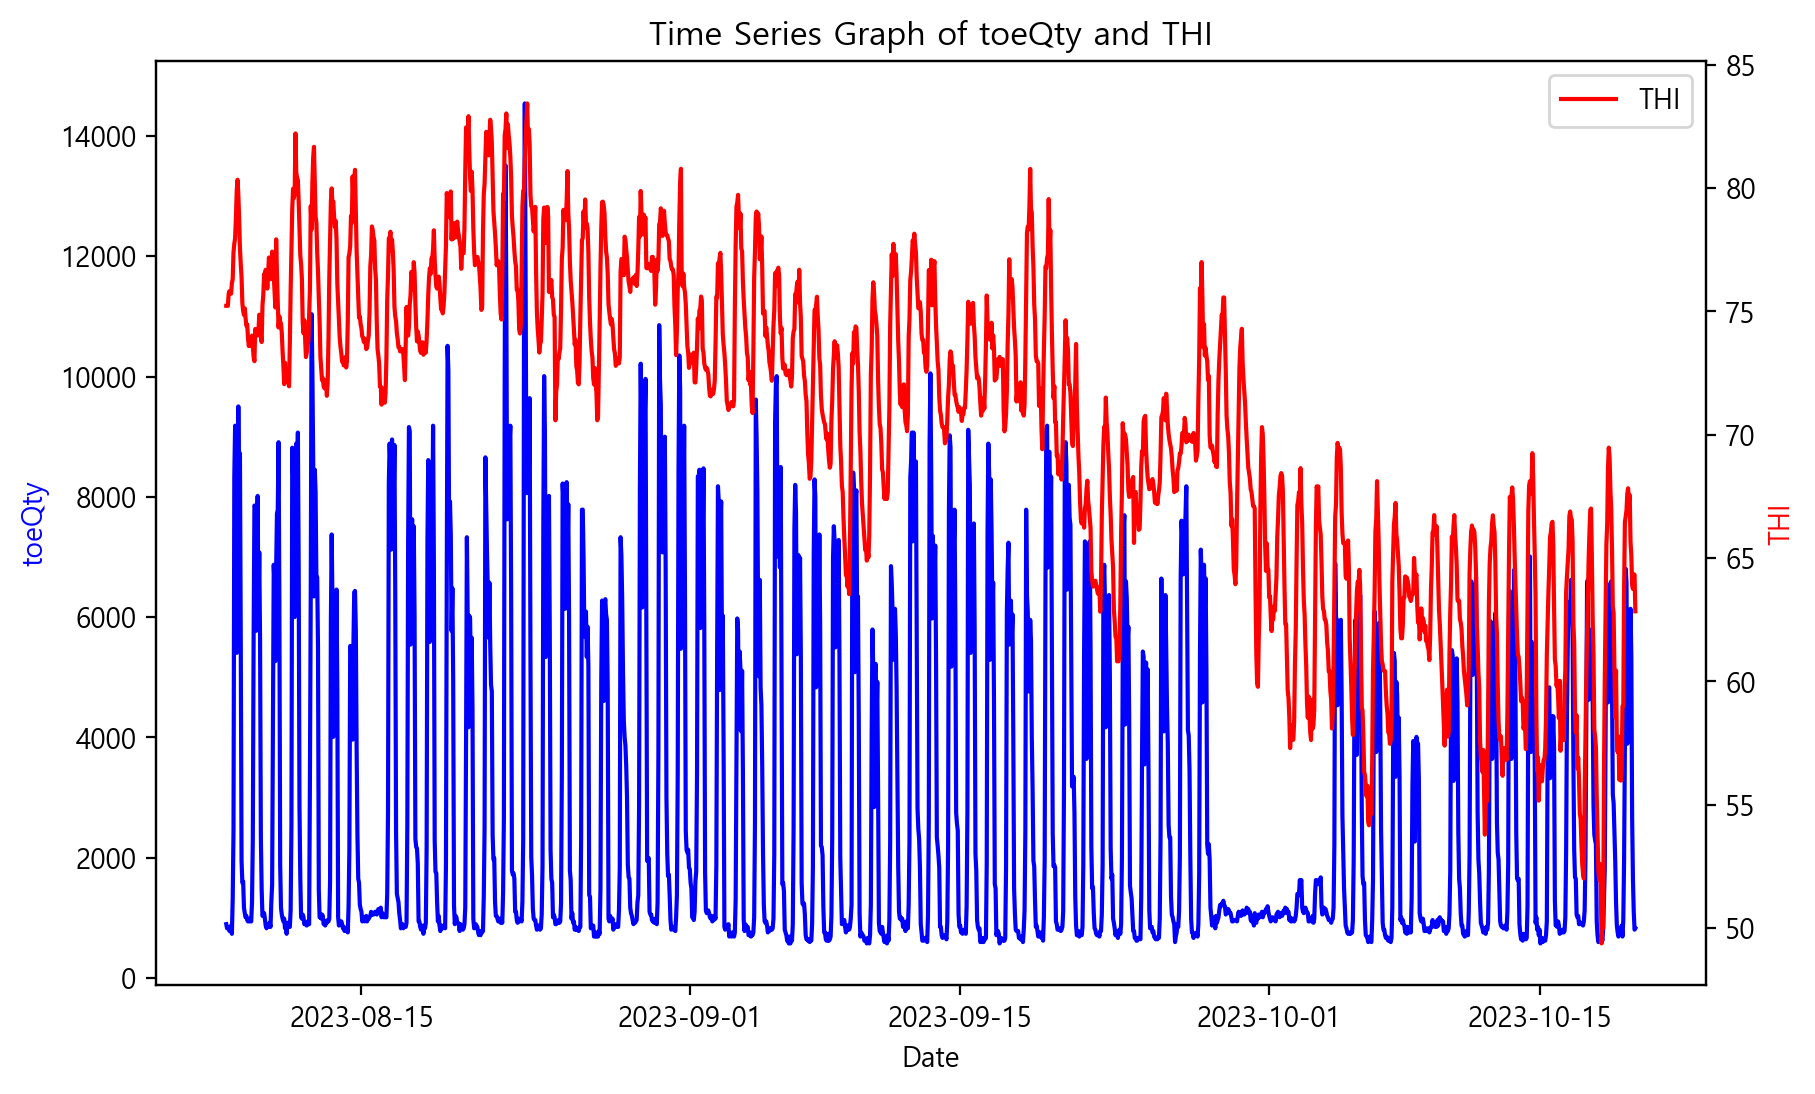

In [88]:
df_1hr_dv_total = df_1hr_dv[df_1hr_dv['useType'] == 'Total']

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(df_1hr_dv_total['useDate'], df_1hr_dv_total['toeQty'], color='blue', label='toeQty')
ax1.set_xlabel('Date')
ax1.set_ylabel('toeQty', color='blue')

ax2 = ax1.twinx()

ax2.plot(df_1hr_dv_total['useDate'], df_1hr_dv_total['THI'], color='red', label='THI')
ax2.set_ylabel('THI', color='red')

plt.title('Time Series Graph of toeQty and THI')
plt.legend()

plt.show()


## WCT - 채감온도

In [89]:
df_1hr_dv['WCT'] = 13.12 + 0.6125*df_1hr_dv['temp'] - 11.37*(df_1hr_dv['wind']**0.16) + 0.3965*(df_1hr_dv['wind']**0.16)*df_1hr_dv['temp']

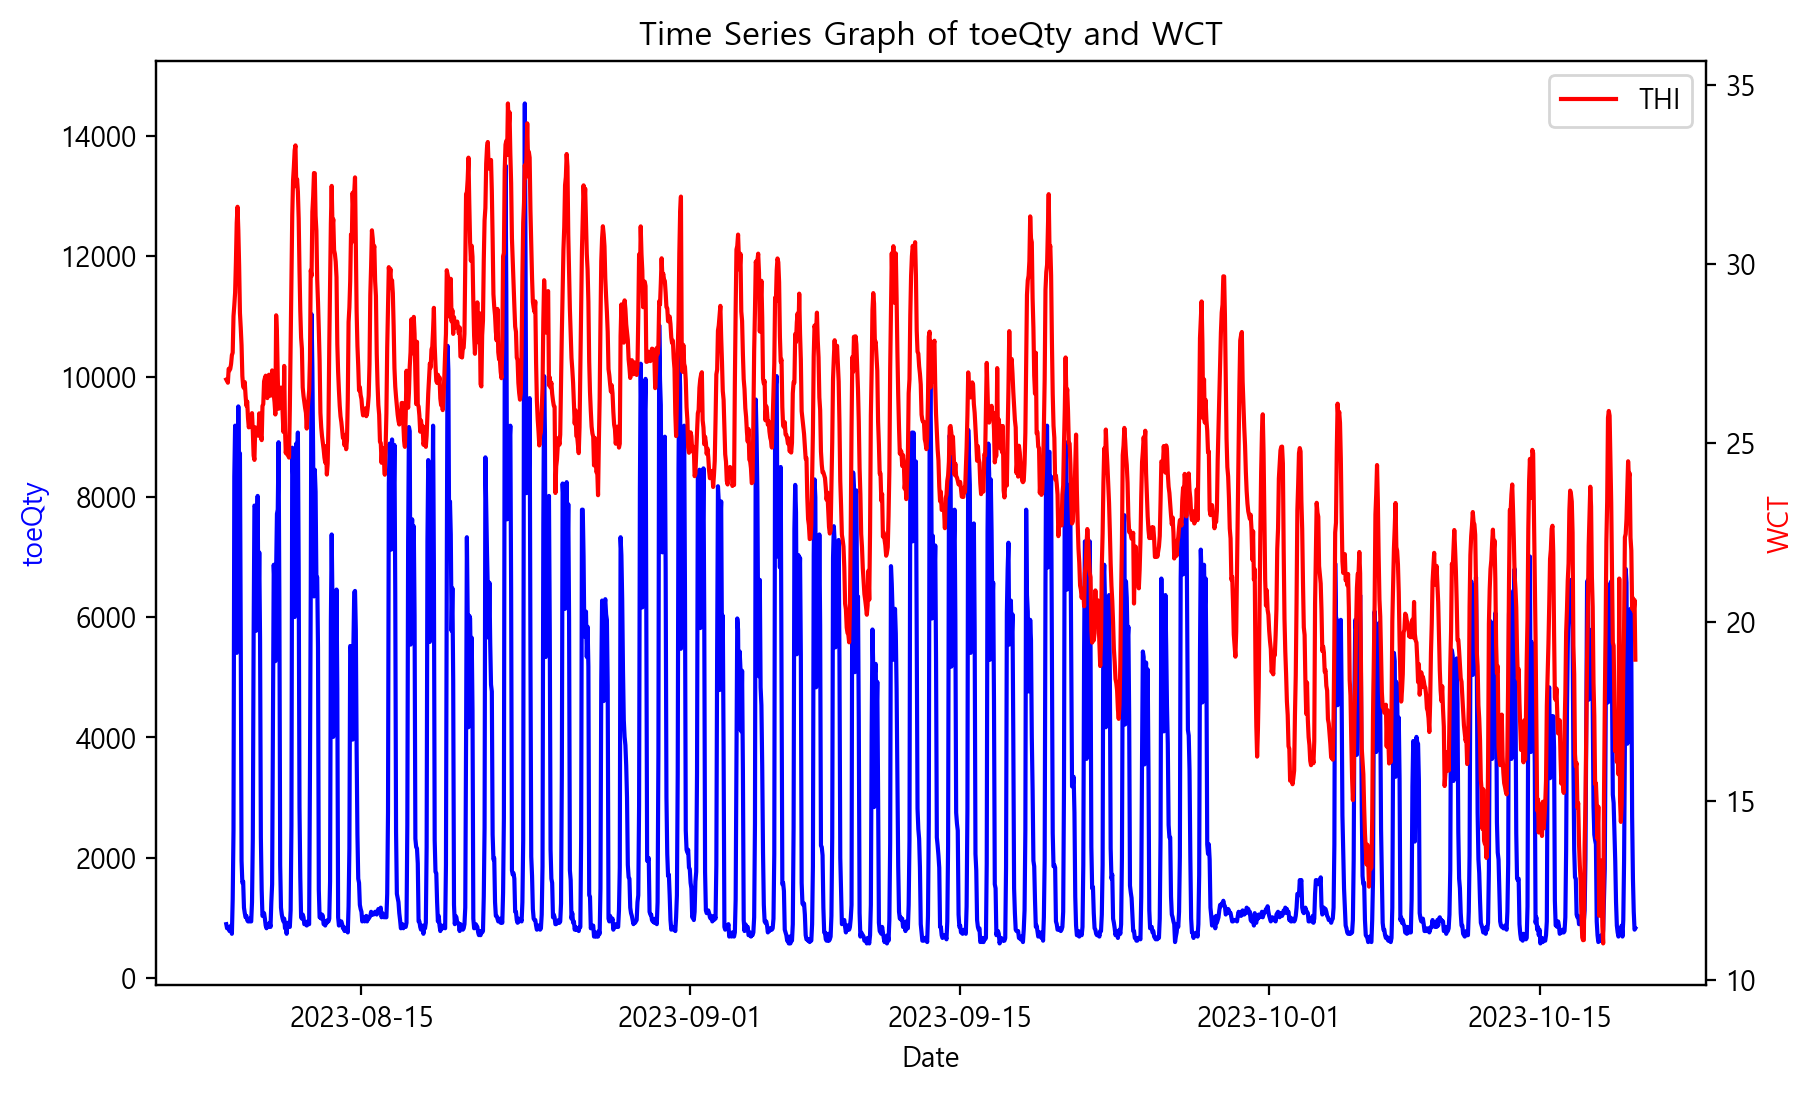

In [90]:
df_1hr_dv_total = df_1hr_dv[df_1hr_dv['useType'] == 'Total']

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(df_1hr_dv_total['useDate'], df_1hr_dv_total['toeQty'], color='blue', label='toeQty')
ax1.set_xlabel('Date')
ax1.set_ylabel('toeQty', color='blue')

ax2 = ax1.twinx()

ax2.plot(df_1hr_dv_total['useDate'], df_1hr_dv_total['WCT'], color='red', label='THI')
ax2.set_ylabel('WCT', color='red')

plt.title('Time Series Graph of toeQty and WCT')
plt.legend()

plt.show()

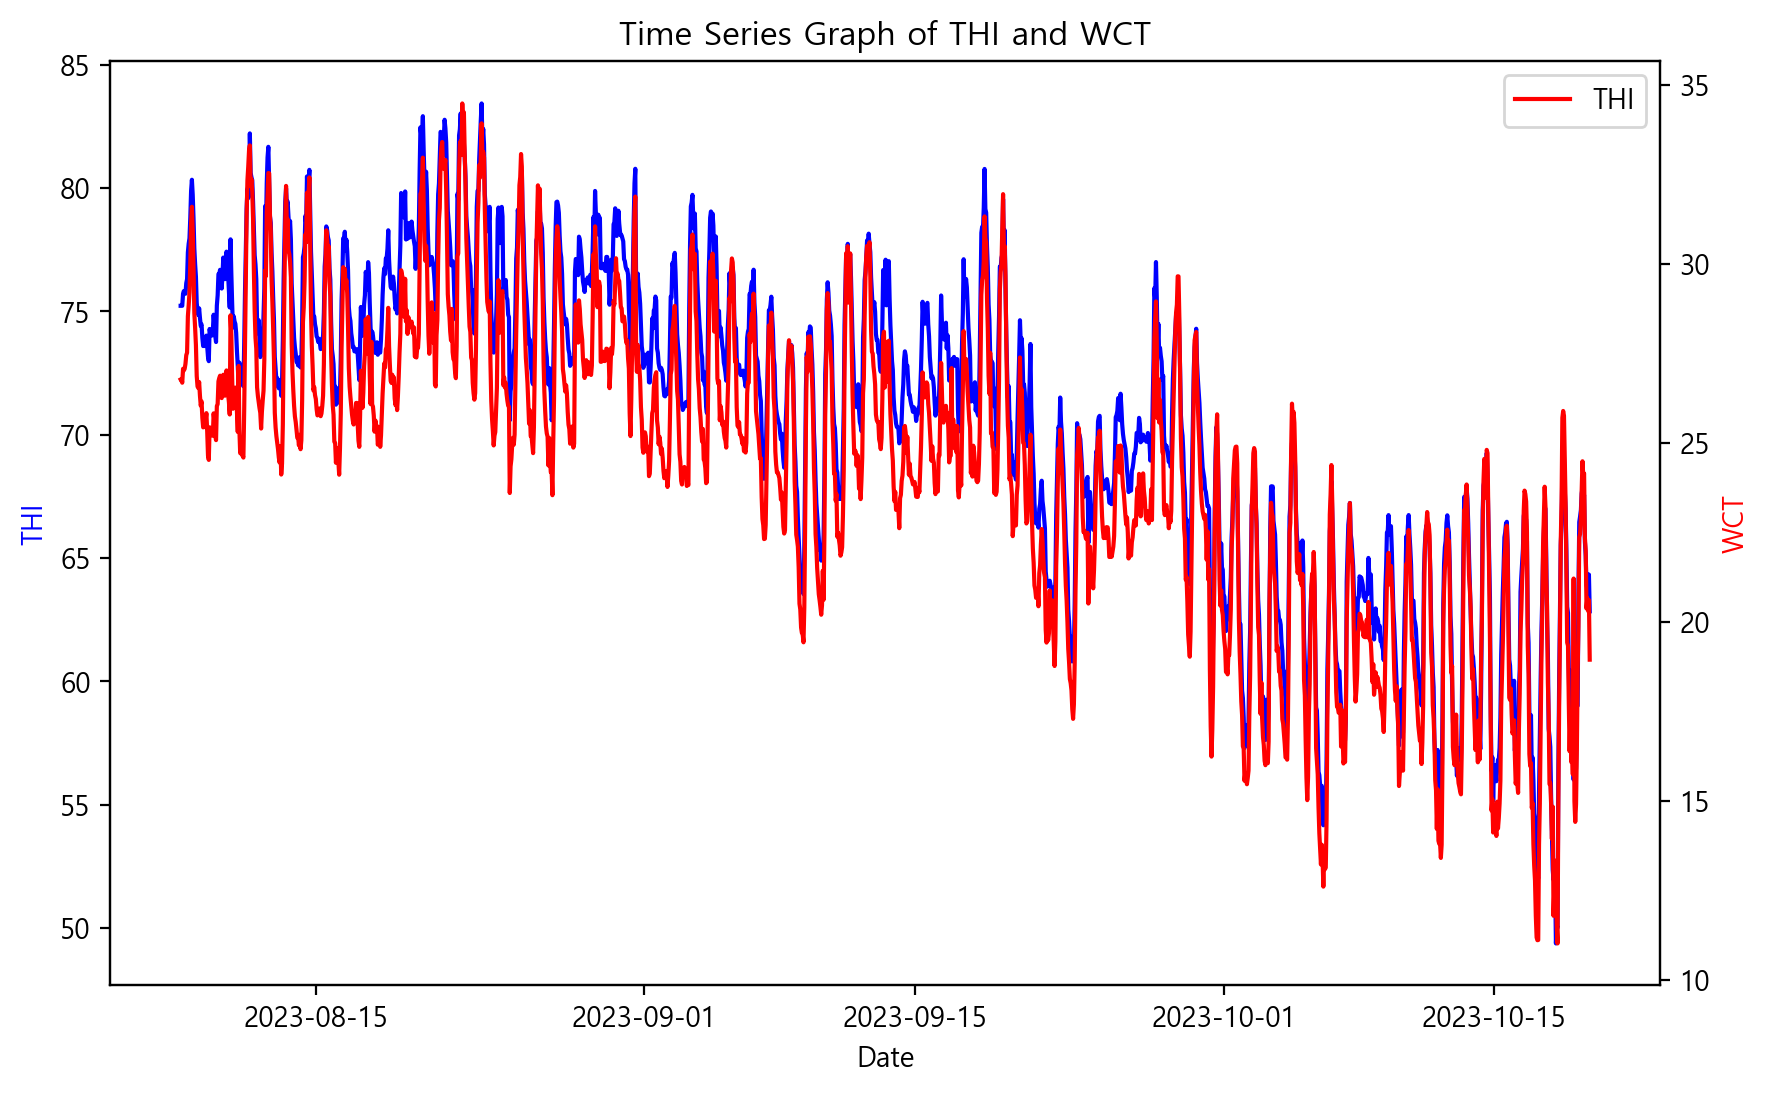

In [91]:
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(df_1hr_dv_total['useDate'], df_1hr_dv_total['THI'], color='blue', label='toeQty')
ax1.set_xlabel('Date')
ax1.set_ylabel('THI', color='blue')

ax2 = ax1.twinx()

ax2.plot(df_1hr_dv_total['useDate'], df_1hr_dv_total['WCT'], color='red', label='THI')
ax2.set_ylabel('WCT', color='red')

plt.title('Time Series Graph of THI and WCT')
plt.legend()

plt.show()

## 냉방도시 - CDH (CDD 개념 차용)

In [92]:
def CDH(xs):
    cumsum = np.cumsum(xs - 24)
    return np.concatenate((cumsum[:11], cumsum[11:] - cumsum[:-11]))

def calculate_and_add_cdh(dataframe):
    temp = dataframe['temp'].values  # 전체 온도 데이터 사용
    cdh = CDH(temp)  # CDH 계산
    return cdh

df_1hr_dv['CDH24'] = calculate_and_add_cdh(df_1hr_dv)

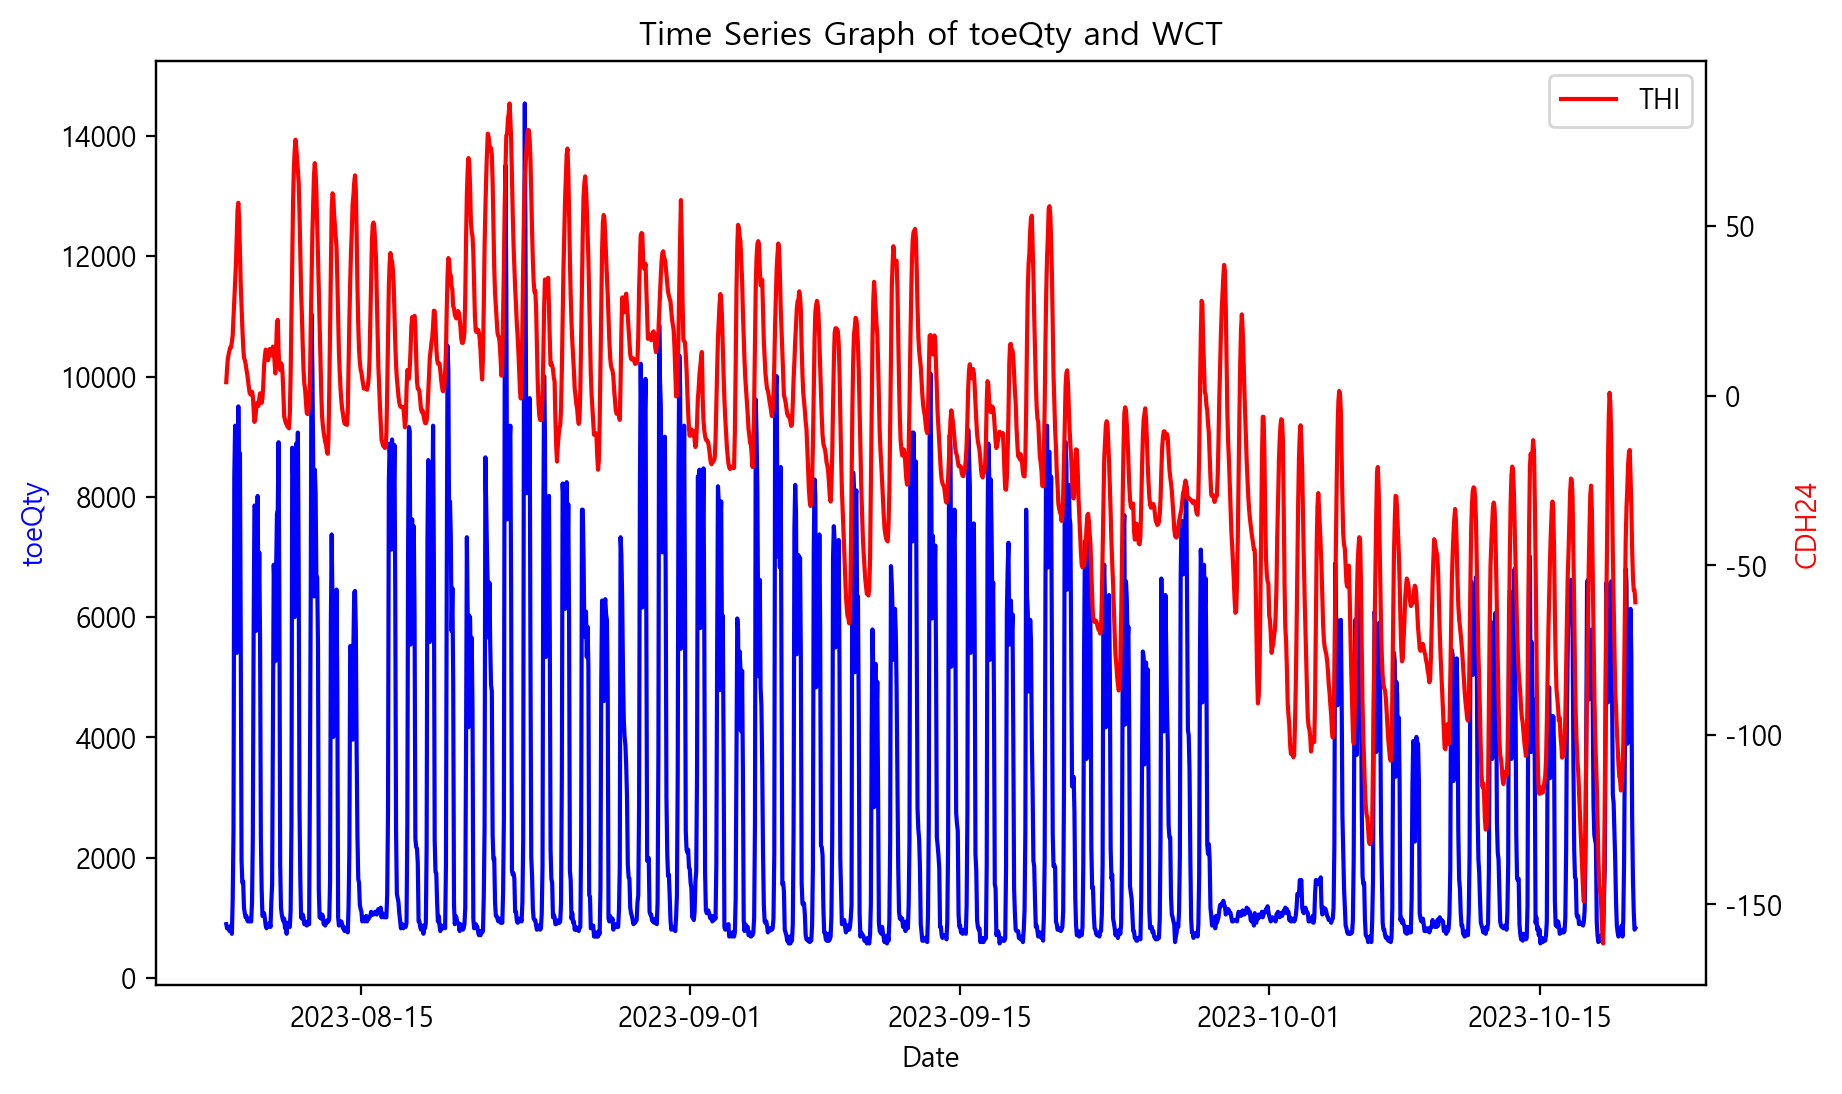

In [93]:
df_1hr_dv_total = df_1hr_dv[df_1hr_dv['useType'] == 'Total']

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(df_1hr_dv_total['useDate'], df_1hr_dv_total['toeQty'], color='blue', label='toeQty')
ax1.set_xlabel('Date')
ax1.set_ylabel('toeQty', color='blue')

ax2 = ax1.twinx()

ax2.plot(df_1hr_dv_total['useDate'], df_1hr_dv_total['CDH24'], color='red', label='THI')
ax2.set_ylabel('CDH24', color='red')

plt.title('Time Series Graph of toeQty and WCT')
plt.legend()

plt.show()

In [94]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(x=df_1hr_dv_total['useDate'], y=df_1hr_dv_total['WCT'], name='THI', mode='lines', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=df_1hr_dv_total['useDate'], y=df_1hr_dv_total['CDH24'], name='WCT', mode='lines', line=dict(color='red')))

fig.update_layout(title='Time Series Graph of toeQty and THI',
                  xaxis_title='Date',
                  yaxis_title='Value')

fig.show()

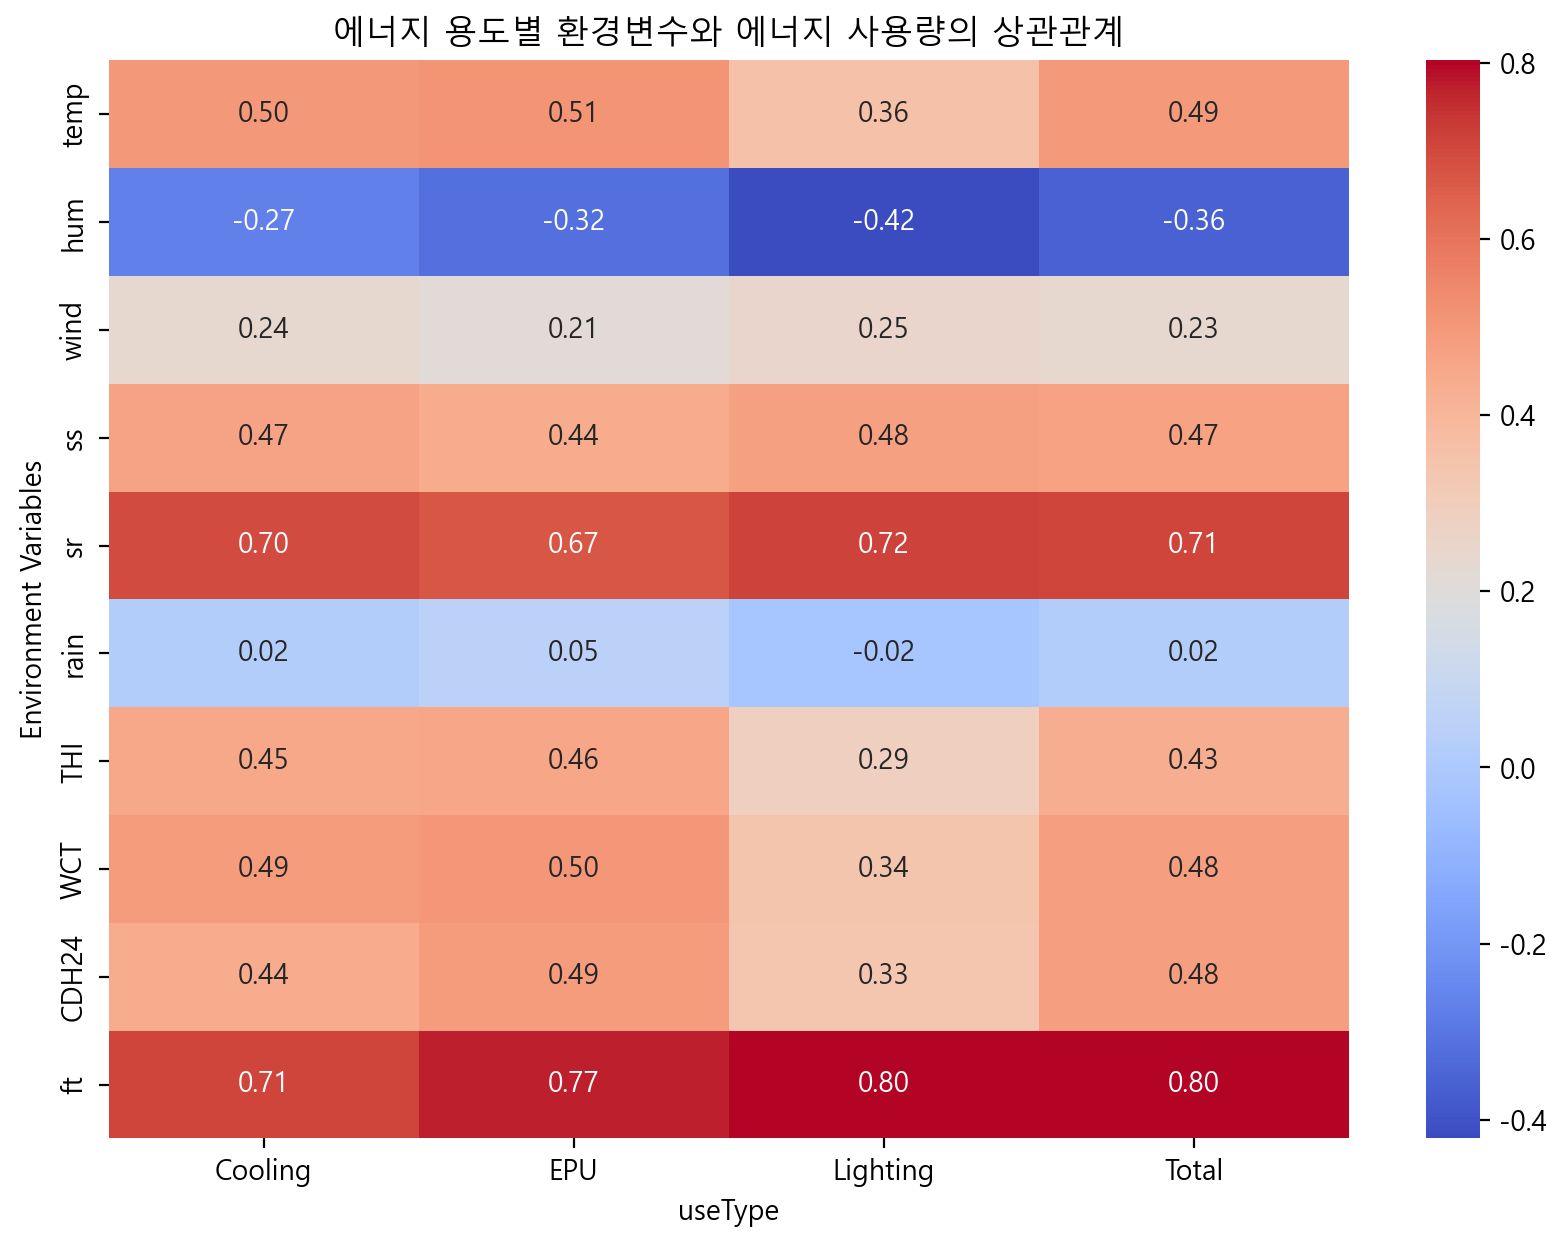

In [95]:
df_1hr_dv_cc = df_1hr_dv[['useDate', 'useType','temp', 'hum', 'wind','ss','sr','rain', 'THI', 'WCT','CDH24', 'ft', 'toeQty']]
corrs = []
for x in df_1hr_dv_cc.useType.unique():
    corr = []
    corr.append(x)
    for feat in ['temp', 'hum', 'wind','ss','sr','rain', 'THI', 'WCT','CDH24', 'ft']:
        corr.append(spearmanr(df_1hr_dv_cc.loc[df_1hr_dv_cc.useType == x, feat], df_1hr_dv_cc.loc[df_1hr_dv_cc.useType == x, 'toeQty']).correlation)
    corrs.append(corr)
    
corr_df = pd.DataFrame(np.array(corrs), columns =  ['useType', 'temp', 'hum', 'wind','ss','sr','rain', 'THI', 'WCT','CDH24', 'ft'])
corr_df.set_index('useType', inplace=True)
corr_df = corr_df.transpose()
corr_df = corr_df.apply(pd.to_numeric, errors='coerce')

plt.figure(figsize=(10, 7))
sns.heatmap(corr_df, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('에너지 용도별 환경변수와 에너지 사용량의 상관관계')
plt.xlabel('useType')
plt.ylabel('Environment Variables')
plt.show()

In [96]:
df_1hr_dv

useDate   useType  toeQty        date  month  day  hour  \
0    2023-08-08 00:00:00   Cooling    68.7  2023-08-08      8    8     0   
1    2023-08-08 00:00:00       EPU   801.5  2023-08-08      8    8     0   
2    2023-08-08 00:00:00  Lighting    22.9  2023-08-08      8    8     0   
3    2023-08-08 00:00:00     Total   893.1  2023-08-08      8    8     0   
4    2023-08-08 01:00:00   Cooling   114.5  2023-08-08      8    8     1   
...                  ...       ...     ...         ...    ...  ...   ...   
7195 2023-10-19 22:00:00     Total   801.5  2023-10-19     10   19    22   
7196 2023-10-19 23:00:00   Cooling    91.6  2023-10-19     10   19    23   
7197 2023-10-19 23:00:00       EPU   687.0  2023-10-19     10   19    23   
7198 2023-10-19 23:00:00  Lighting    45.8  2023-10-19     10   19    23   
7199 2023-10-19 23:00:00     Total   824.4  2023-10-19     10   19    23   

      weekday  holiday  temp  rain  wind  hum   ss   sr  operating  \
0           1        0  25.0   0.0   2.3   83  0.0  0.0          0   
1           1        0  25.0   0.0   2.3   83  0.0  0.0          0   
2           1        0  25.0   0.0   2.3   83  0.0  0.0          0   
3           1        0  25.0   0.0   2.3   83  0.0  0.0          0   
4           1        0  25.0   0.0   2.2   83  0.0  0.0          0   
...       ...      ...   ...   ...   ...  ...  ...  ...        ...   
7195        3        0  18.8   0.0   1.2   65  0.0  0.0          0   
7196        3        0  17.8   0.0   2.8   64  0.0  0.0          0   
7197        3        0  17.8   0.0   2.8   64  0.0  0.0          0   
7198        3        0  17.8   0.0   2.8   64  0.0  0.0          0   
7199        3        0  17.8   0.0   2.8   64  0.0  0.0          0   

               ft       THI        WCT  CDH24  
0    -2271.376966  75.22350  26.767229    1.0  
1    -2271.376966  75.22350  26.767229    2.0  
2    -2271.376966  75.22350  26.767229    3.0  
3    -2271.376966  75.22350  26.767229    4.0  
4    -2553.643187  75.22350  26.779030    5.0  
...           ...       ...        ...    ...  
7195 -1151.046743  64.33080  20.603288  -57.4  
7196 -1792.977440  62.84408  18.937930  -58.2  
7197 -1792.977440  62.84408  18.937930  -59.0  
7198 -1792.977440  62.84408  18.937930  -59.8  
7199 -1792.977440  62.84408  18.937930  -60.9  

[7200 rows x 20 columns]

In [97]:
# Calculate 'day_hour_mean'
toeQty_mean = pd.pivot_table(df_1hr_dv, values='toeQty', index=['hour', 'weekday'], aggfunc=np.mean).reset_index()
toeQty_mean.columns = ['hour', 'weekday', 'day_hour_mean']

# Calculate 'day_hour_std'
toeQty_std = pd.pivot_table(df_1hr_dv, values='toeQty', index=['hour', 'weekday'], aggfunc=np.std).reset_index()
toeQty_std.columns = ['hour', 'weekday', 'day_hour_std']

# Calculate 'hour_mean'
toeQty_hour_mean = pd.pivot_table(df_1hr_dv, values='toeQty', index=['hour'], aggfunc=np.mean).reset_index()
toeQty_hour_mean.columns = ['hour', 'hour_mean']

# Calculate 'hour_std'
toeQty_hour_std = pd.pivot_table(df_1hr_dv, values='toeQty', index=['hour'], aggfunc=np.std).reset_index()
toeQty_hour_std.columns = ['hour', 'hour_std']

# Merge calculated features to 'df_1hr_dv' and 'test' dataframes
df_1hr_dv = df_1hr_dv.merge(toeQty_mean, on=['hour', 'weekday'], how='left')


df_1hr_dv = df_1hr_dv.merge(toeQty_std, on=['hour', 'weekday'], how='left')

df_1hr_dv = df_1hr_dv.merge(toeQty_hour_mean, on=['hour'], how='left')

df_1hr_dv = df_1hr_dv.merge(toeQty_hour_std, on=['hour'], how='left')

df_1hr_dv = df_1hr_dv.reset_index(drop=True)

In [100]:
train_dv_st_df = df_1hr_dv[('2023-08-14 00:00:00.000'<= df_1hr_dv['useDate']) & (df_1hr_dv['useDate'] < '2023-10-16 00:00:00.000')]
test_dv_st_df = df_1hr_dv[('2023-08-14 00:00:00.000' > df_1hr_dv['useDate']) | (df_1hr_dv['useDate'] >= '2023-10-16 00:00:00.000')]
train_dv_st_df.to_csv('data/train_dv_st_df.csv')
test_dv_st_df.to_csv('data/test_dv_st_df.csv')